In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import Dataset, DataLoader
import io
import requests
import zipfile
import os
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability [used colab]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variables for later use
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Using device: cuda


In [ ]:
# Dataset 1: IMDb Reviews Dataset - Download and load
def download_imdb_dataset():
    # Check if file already exists
    if not os.path.exists('imdb_dataset.csv'):
        print("Downloading IMDb Dataset...")
        url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
        r = requests.get(url, stream=True)
        with open('aclImdb_v1.tar.gz', 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            for chunk in tqdm(r.iter_content(chunk_size=1024), total=(total_length // 1024) + 1):
                if chunk:
                    f.write(chunk)

        # Extract the dataset
        import tarfile
        with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
            tar.extractall()

        # Process the extracted data
        pos_files = os.listdir('aclImdb/train/pos')
        neg_files = os.listdir('aclImdb/train/neg')

        data = []
        for file_name in tqdm(pos_files):
            if file_name.endswith('.txt'):
                with open(os.path.join('aclImdb/train/pos', file_name), 'r', encoding='utf-8') as f:
                    data.append({'text': f.read(), 'sentiment': 'positive'})

        for file_name in tqdm(neg_files):
            if file_name.endswith('.txt'):
                with open(os.path.join('aclImdb/train/neg', file_name), 'r', encoding='utf-8') as f:
                    data.append({'text': f.read(), 'sentiment': 'negative'})

        # Convert to DataFrame and save
        df_imdb = pd.DataFrame(data)
        # Sample 10,000 reviews to make it manageable
        df_imdb = df_imdb.sample(10000, random_state=42)
        df_imdb.to_csv('imdb_dataset.csv', index=False)

        # Clean up
        import shutil
        shutil.rmtree('aclImdb', ignore_errors=True)
        os.remove('aclImdb_v1.tar.gz')

        print("IMDb Dataset processed and saved.")
    else:
        print("IMDb Dataset already exists. Loading from file.")

    return pd.read_csv('imdb_dataset.csv')

# Dataset 2: Twitter Sentiment Analysis Dataset
def download_twitter_dataset():
    if not os.path.exists('twitter_sentiment.csv'):
        print("Downloading Twitter Sentiment Dataset...")
        url = "https://raw.githubusercontent.com/dkakkar/Twitter-Sentiment-Analysis/master/training.1600000.processed.noemoticon.csv"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.content.decode('latin-1')
            cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']
            df = pd.read_csv(io.StringIO(data), encoding='latin-1', names=cols)
            # Map sentiment: 0 = negative, 4 = positive
            df['sentiment'] = df['sentiment'].map({0: 'negative', 4: 'positive'})
            # Keep only sentiment and text
            df = df[['sentiment', 'text']]
            # Sample 10,000 tweets to make it manageable
            df = df.sample(10000, random_state=42)
            df.to_csv('twitter_sentiment.csv', index=False)
            print("Twitter Dataset processed and saved.")
        else:
            print("Failed to download Twitter dataset. Trying alternate source...")
            url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
            response = requests.get(url)
            if response.status_code == 200:
                data = response.content.decode('utf-8')
                df = pd.read_csv(io.StringIO(data))
                # Sample 10,000 reviews from this alternate source
                df = df.sample(10000, random_state=42)
                df.to_csv('twitter_sentiment.csv', index=False)
                print("Alternative dataset processed and saved.")
            else:
                print("Failed to download dataset. Please try again later.")
                return None
    else:
        print("Twitter Sentiment Dataset already exists. Loading from file.")

    return pd.read_csv('twitter_sentiment.csv')

# Dataset 3: SMS Spam Collection
def download_sms_spam_dataset():
    if not os.path.exists('sms_spam.csv'):
        print("Downloading SMS Spam Dataset...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()

        with open('SMSSpamCollection', 'r', encoding='utf-8') as file:
            lines = file.readlines()
            data = []
            for line in lines:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    label, message = parts
                    data.append({'label': label, 'message': message})

        df_sms = pd.DataFrame(data)
        # Rename columns for consistency
        df_sms.columns = ['sentiment', 'text']
        # Map ham/spam to positive/negative for consistency with other datasets
        df_sms['sentiment'] = df_sms['sentiment'].map({'ham': 'ham', 'spam': 'spam'})
        df_sms.to_csv('sms_spam.csv', index=False)

        # Clean up
        os.remove('SMSSpamCollection')
        print("SMS Spam Dataset processed and saved.")
    else:
        print("SMS Spam Dataset already exists. Loading from file.")

    return pd.read_csv('sms_spam.csv')

# Load all three datasets
print("Loading datasets...")
try:
    df_imdb = download_imdb_dataset()
    df_twitter = download_twitter_dataset()
    df_sms = download_sms_spam_dataset()
    print("All datasets loaded successfully!")
except Exception as e:
    print(f"Error loading datasets: {e}")

Loading datasets...


  0%|          | 0/82155 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

IMDb Dataset processed and saved.
Failed to download Twitter dataset. Trying alternate source...
Alternative dataset processed and saved.
SMS Spam Dataset processed and saved.
All datasets loaded successfully!


In [4]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
print(df_imdb.columns)
print(df_twitter.columns)
print(df_sms.columns)

Index(['text', 'sentiment'], dtype='object')
Index(['review', 'sentiment'], dtype='object')
Index(['sentiment', 'text'], dtype='object')



Performing EDA and preprocessing on datasets...

----- EDA for IMDb Dataset -----
Dataset shape: (10000, 2)
Column names: ['text', 'sentiment']

Class distribution:
sentiment
positive    5038
negative    4962
Name: count, dtype: int64


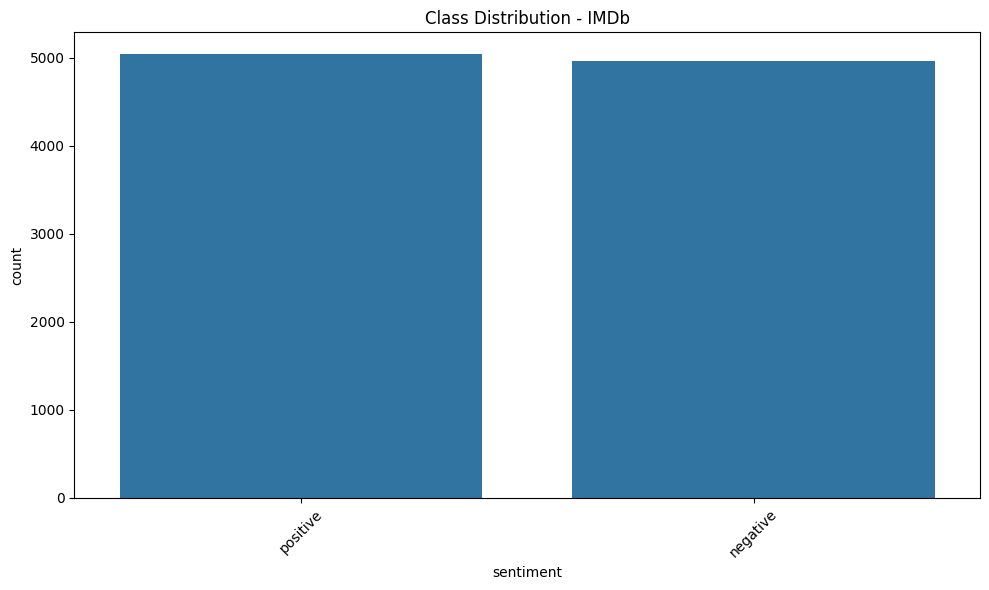


Text length statistics:
count    10000.000000
mean       236.876900
std        176.638745
min         10.000000
25%        128.000000
50%        177.000000
75%        288.000000
max       1839.000000
Name: text_length, dtype: float64


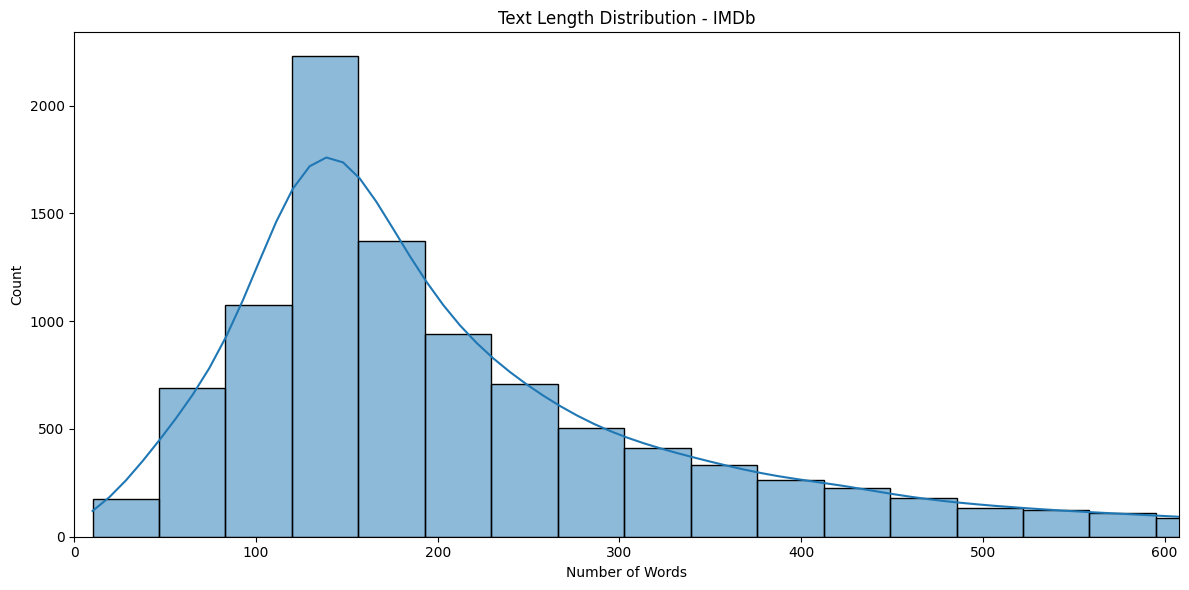


Total number of words: 2368769
Vocabulary size (unique words): 159381

Top 20 most common words:
     Word   Count
0     the  116383
1       a   62857
2     and   61764
3      of   58204
4      to   53815
5      is   41956
6      in   34590
7       I   26553
8    that   26215
9    this   23088
10     it   21939
11  /><br   20856
12    was   18576
13     as   17453
14   with   16894
15    for   16562
16    The   13751
17    but   13611
18     on   12409
19  movie   12251


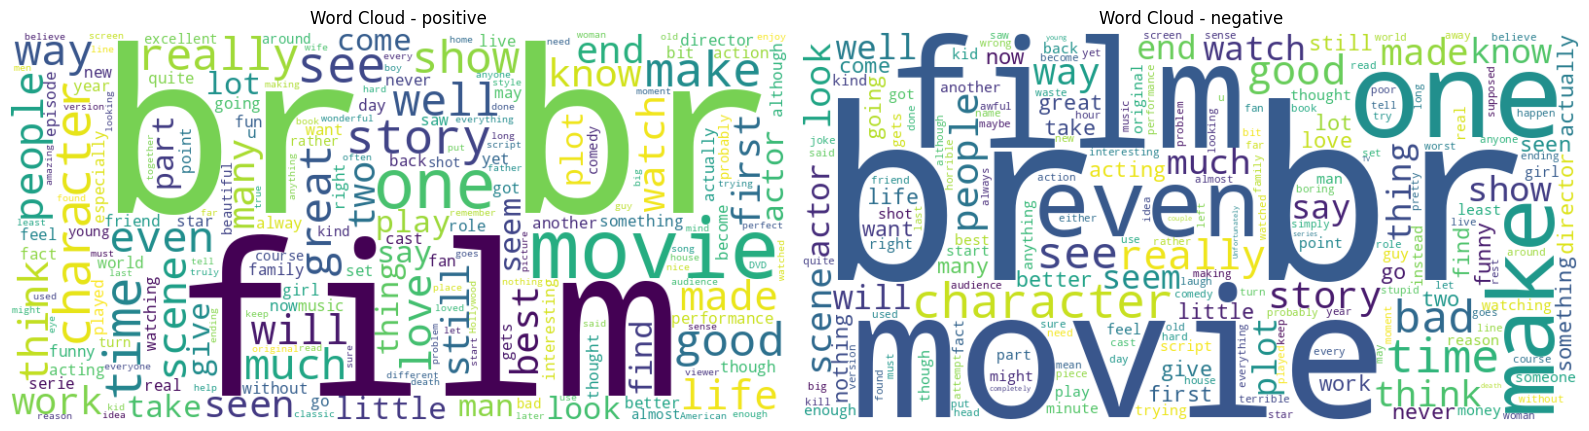

Preprocessing IMDb dataset...
IMDb preprocessing completed.

----- EDA for Twitter Dataset -----
Dataset shape: (10000, 2)
Column names: ['review', 'sentiment']

Class distribution:
sentiment
positive    5039
negative    4961
Name: count, dtype: int64


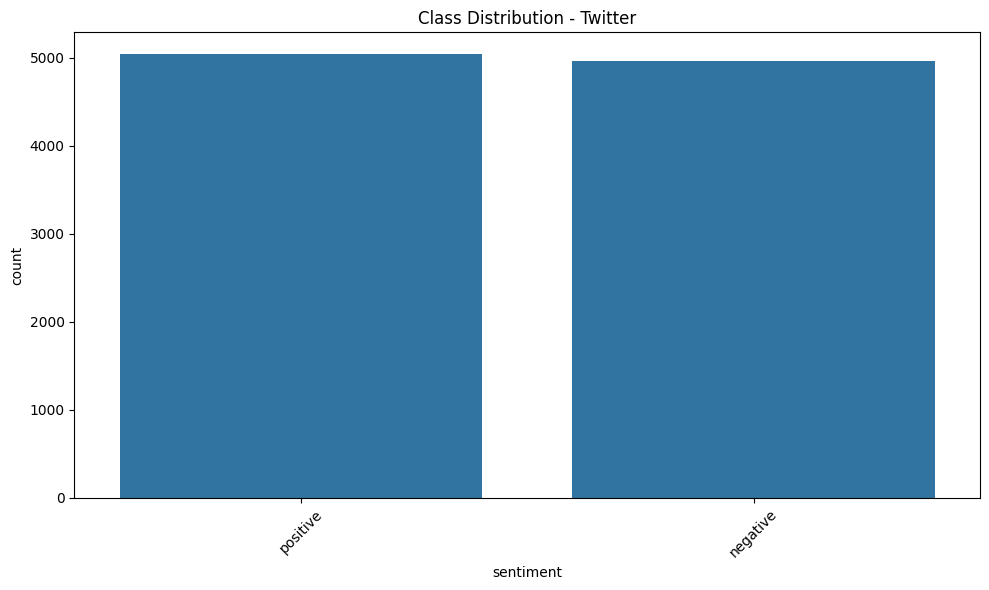


Text length statistics:
count    10000.000000
mean       231.759000
std        170.274063
min          9.000000
25%        126.000000
50%        173.000000
75%        282.000000
max       1316.000000
Name: text_length, dtype: float64


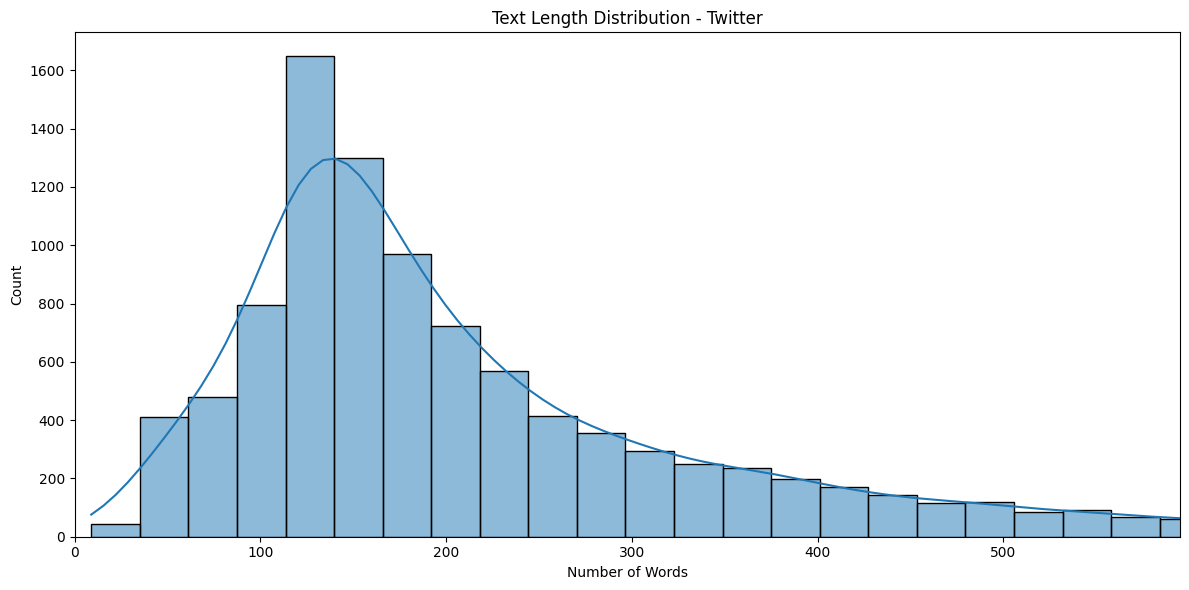


Total number of words: 2317590
Vocabulary size (unique words): 158898

Top 20 most common words:
     Word   Count
0     the  113580
1       a   61942
2     and   60698
3      of   57051
4      to   52553
5      is   40633
6      in   34362
7       I   26226
8    that   25152
9    this   22873
10     it   21619
11  /><br   20022
12    was   18444
13   with   16786
14     as   16627
15    for   16281
16    The   13456
17    but   13270
18  movie   12344
19     on   12249


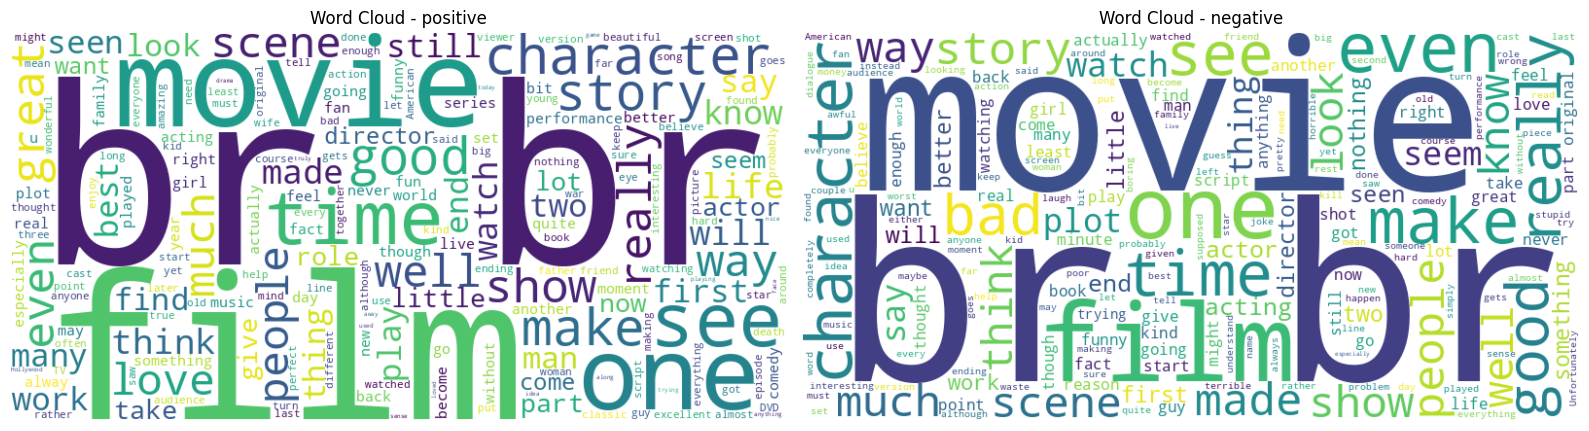

Preprocessing Twitter dataset...
Twitter preprocessing completed.

----- EDA for SMS Spam Dataset -----
Dataset shape: (5574, 2)
Column names: ['sentiment', 'text']

Class distribution:
sentiment
ham     4827
spam     747
Name: count, dtype: int64


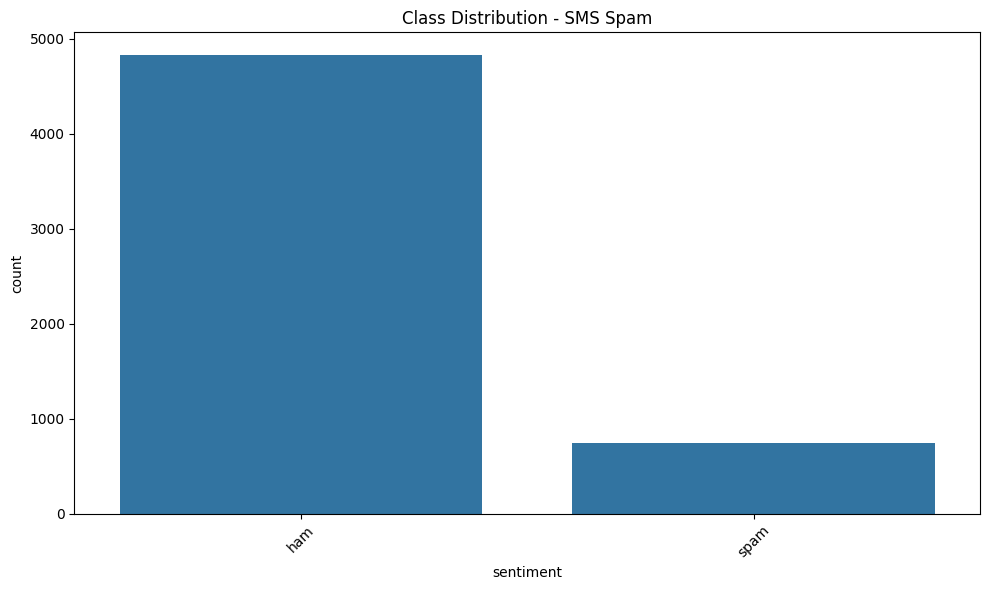


Text length statistics:
count    5574.000000
mean       15.591676
std        11.390454
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: text_length, dtype: float64


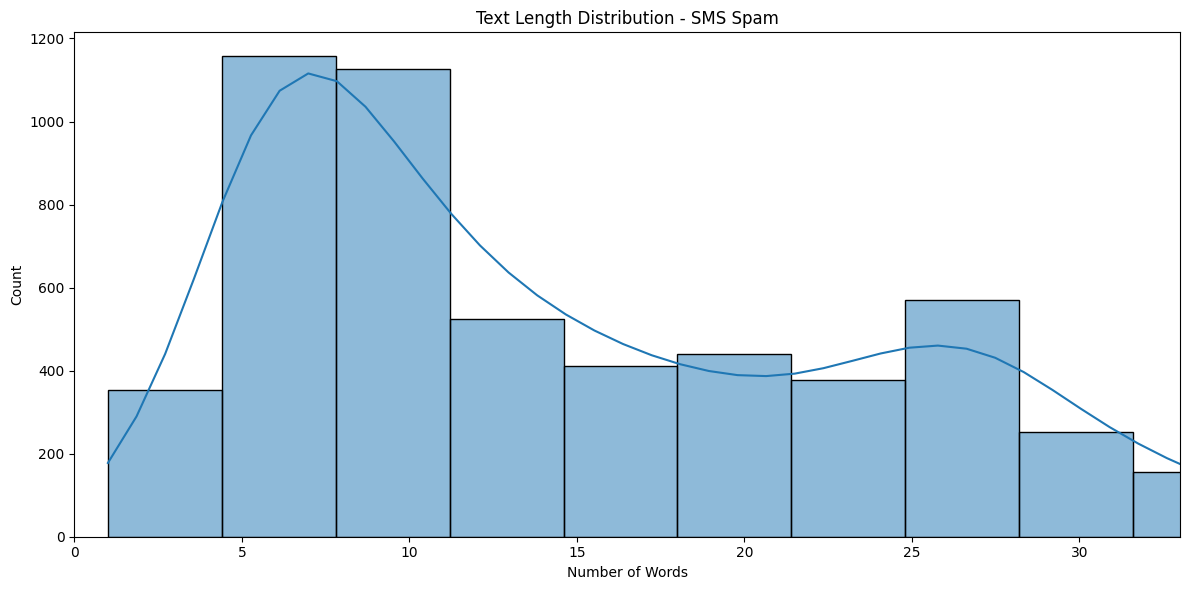


Total number of words: 86908
Vocabulary size (unique words): 15733

Top 20 most common words:
    Word  Count
0     to   2145
1    you   1626
2      I   1469
3      a   1337
4    the   1207
5    and    858
6     in    800
7     is    788
8      i    748
9      u    698
10   for    650
11    my    630
12    of    592
13    me    561
14  your    561
15    on    488
16  have    477
17     2    457
18  that    422
19    it    397


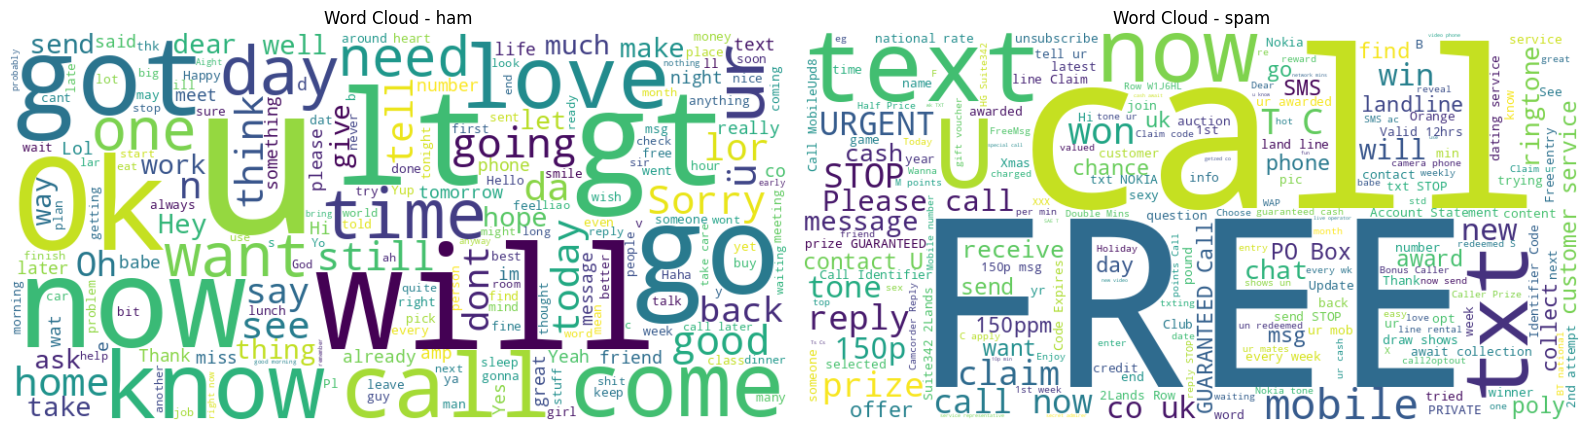

Preprocessing SMS Spam dataset...
SMS Spam preprocessing completed.


In [ ]:
# Text Preprocessing Functions
def preprocess_text(text):
   """
   Preprocess text: lowercase, remove punctuation/numbers/stopwords, lemmatize
   """
   if isinstance(text, str):
       # Convert to lowercase
       text = text.lower()

       # Remove punctuation
       text = re.sub(f'[{string.punctuation}]', ' ', text)

       # Remove numbers
       text = re.sub(r'\d+', '', text)

       # Tokenize
       tokens = word_tokenize(text)

       # Remove stopwords and lemmatize
       processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]

       # Join tokens back into a string
       return ' '.join(processed_tokens)
   else:
       return ""

# Function to perform EDA on text data
def perform_eda(df, dataset_name):
   """
   Perform exploratory data analysis on text dataset
   """
   print(f"\n----- EDA for {dataset_name} Dataset -----")

   # Display basic information
   print(f"Dataset shape: {df.shape}")
   print(f"Column names: {df.columns.tolist()}")

   # Class distribution
   print("\nClass distribution:")
   class_dist = df['sentiment'].value_counts()
   print(class_dist)

   # Create class distribution plot
   plt.figure(figsize=(10, 6))
   sns.countplot(x='sentiment', data=df)
   plt.title(f'Class Distribution - {dataset_name}')
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

   # Calculate text length statistics
   text_col = 'text' if 'text' in df.columns else 'review'
   df['text_length'] = df[text_col].apply(lambda x: len(str(x).split()))

   # Text length statistics
   print("\nText length statistics:")
   print(df['text_length'].describe())

   # Visualize text length distribution
   plt.figure(figsize=(12, 6))
   sns.histplot(df['text_length'], bins=50, kde=True)
   plt.title(f'Text Length Distribution - {dataset_name}')
   plt.xlabel('Number of Words')
   plt.xlim(0, df['text_length'].quantile(0.95))
   plt.tight_layout()
   plt.show()

   # Word counts and vocabulary
   all_text = ' '.join(df[text_col].astype(str).tolist())
   words = all_text.split()
   print(f"\nTotal number of words: {len(words)}")
   print(f"Vocabulary size (unique words): {len(set(words))}")

   # Most common words
   from collections import Counter
   word_counts = Counter(words)
   print("\nTop 20 most common words:")
   print(pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count']))

   # Generate word clouds for each class
   classes = df['sentiment'].unique()
   fig, axes = plt.subplots(1, len(classes), figsize=(16, 8))

   for i, label in enumerate(classes):
       class_text = ' '.join(df[df['sentiment'] == label][text_col].astype(str))
       if len(class_text) > 0:
           wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(class_text)
           if len(classes) > 1:
               axes[i].imshow(wordcloud, interpolation='bilinear')
               axes[i].set_title(f'Word Cloud - {label}')
               axes[i].axis('off')
           else:
               axes.imshow(wordcloud, interpolation='bilinear')
               axes.set_title(f'Word Cloud - {label}')
               axes.axis('off')

   plt.tight_layout()
   plt.show()

   return df

# Apply preprocessing and EDA to each dataset
print("\nPerforming EDA and preprocessing on datasets...")

# For IMDb dataset
if 'df_imdb' in locals() and df_imdb is not None:
   # Make a copy to avoid modifying original data
   imdb_processed = df_imdb.copy()
   # Identify text column
   imdb_text_col = 'text' if 'text' in imdb_processed.columns else 'review'
   # Perform EDA
   imdb_processed = perform_eda(imdb_processed, "IMDb")
   # Apply preprocessing to text column
   print("Preprocessing IMDb dataset...")
   imdb_processed['processed_text'] = imdb_processed[imdb_text_col].apply(preprocess_text)
   print("IMDb preprocessing completed.")

# For Twitter dataset
if 'df_twitter' in locals() and df_twitter is not None:
   twitter_processed = df_twitter.copy()
   twitter_text_col = 'text' if 'text' in twitter_processed.columns else 'review'
   twitter_processed = perform_eda(twitter_processed, "Twitter")
   print("Preprocessing Twitter dataset...")
   twitter_processed['processed_text'] = twitter_processed[twitter_text_col].apply(preprocess_text)
   print("Twitter preprocessing completed.")

# For SMS Spam dataset
if 'df_sms' in locals() and df_sms is not None:
   sms_processed = df_sms.copy()
   sms_processed = perform_eda(sms_processed, "SMS Spam")
   print("Preprocessing SMS Spam dataset...")
   sms_processed['processed_text'] = sms_processed['text'].apply(preprocess_text)
   print("SMS Spam preprocessing completed.")

In [ ]:
# Feature Extraction Functions
def extract_features(df, feature_type='bow', max_features=5000):
    """
    Extract features from text using Bag of Words or TF-IDF
    """
    if feature_type == 'bow':
        vectorizer = CountVectorizer(max_features=max_features)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features)
    else:
        raise ValueError("feature_type must be 'bow' or 'tfidf'")

    X = vectorizer.fit_transform(df['processed_text'])
    y = df['sentiment']

    return X, y, vectorizer

# ML Model Training and Evaluation Functions
def train_and_evaluate_models(X_train, X_test, y_train, y_test, dataset_name, feature_type):
    """
    Train and evaluate multiple ML models on the dataset
    """
    # Define models to train
    models = {
        'Multinomial Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Linear SVM': LinearSVC(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }

    # Define parameters for Grid Search
    param_grids = {
        'Multinomial Naive Bayes': {
            'alpha': [0.1, 1.0]
        },
        'Logistic Regression': {
            'C': [0.1, 1.0],
            'penalty': ['l2']
        },
        'Linear SVM': {
            'C': [0.1, 1.0],
            'loss': ['hinge']
        },
        'Random Forest': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10]
        }
    }

    # Results storage
    results = []
    best_score = 0
    best_model = None

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name} on {dataset_name} using {feature_type}...")

        grid_search = GridSearchCV(
            model,
            param_grids[model_name],
            cv=3,
            scoring='f1',
            n_jobs=1
        )

        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_

        # Get the best model from grid search
        model = grid_search.best_estimator_

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        if len(set(y_train)) == 2:
            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test == list(set(y_train))[1], y_pred_proba)
            else:
                try:
                    y_score = model.decision_function(X_test)
                    roc_auc = roc_auc_score(y_test == list(set(y_train))[1], y_score)
                except:
                    roc_auc = "N/A"
        else:
            roc_auc = "N/A"

        # Store results
        result = {
            'Dataset': dataset_name,
            'Feature Type': feature_type,
            'Model': model_name,
            'Best Parameters': str(best_params),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }
        results.append(result)

        # Print evaluation results
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc}")
        print(f"Best Parameters: {best_params}")

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix - {model_name} on {dataset_name} ({feature_type})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # Update best model if better F1 score
        if f1 > best_score:
            best_score = f1
            best_model = model

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df, best_model


Starting machine learning experiments...

=== Running BOW on IMDb Dataset ===
Training set shape: (8000, 5000)
Test set shape: (2000, 5000)

Training Multinomial Naive Bayes on IMDb using bow...
Accuracy: 0.8410
Precision: 0.8415
Recall: 0.8410
F1 Score: 0.8410
ROC AUC: 0.901565200172811
Best Parameters: {'alpha': 0.1}

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.86      0.84       992
    positive       0.86      0.82      0.84      1008

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



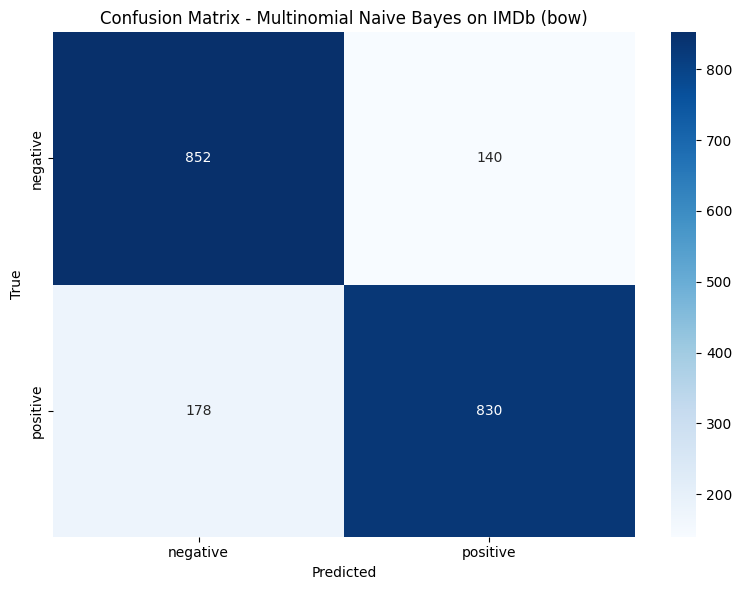


Training Logistic Regression on IMDb using bow...
Accuracy: 0.8505
Precision: 0.8505
Recall: 0.8505
F1 Score: 0.8505
ROC AUC: 0.9258952572964669
Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85       992
    positive       0.85      0.85      0.85      1008

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



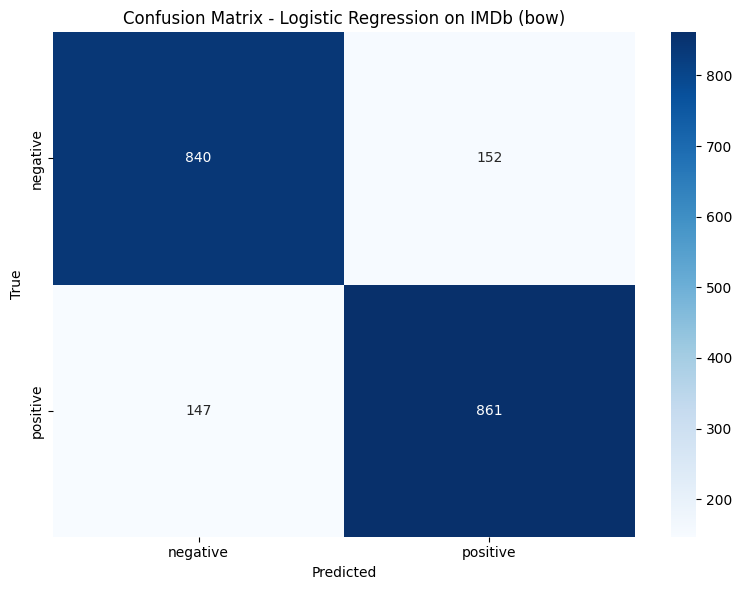


Training Linear SVM on IMDb using bow...
Accuracy: 0.8240
Precision: 0.8240
Recall: 0.8240
F1 Score: 0.8240
ROC AUC: 0.9060099846390168
Best Parameters: {'C': 0.1, 'loss': 'hinge'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.82      0.82       992
    positive       0.83      0.82      0.83      1008

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



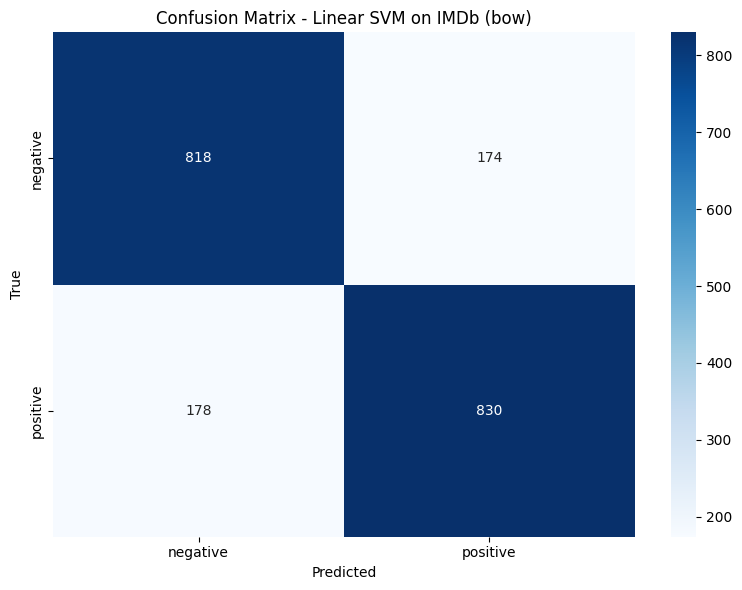


Training Random Forest on IMDb using bow...
Accuracy: 0.8140
Precision: 0.8154
Recall: 0.8140
F1 Score: 0.8139
ROC AUC: 0.8984750024001535
Best Parameters: {'max_depth': None, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.84      0.82       992
    positive       0.84      0.78      0.81      1008

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



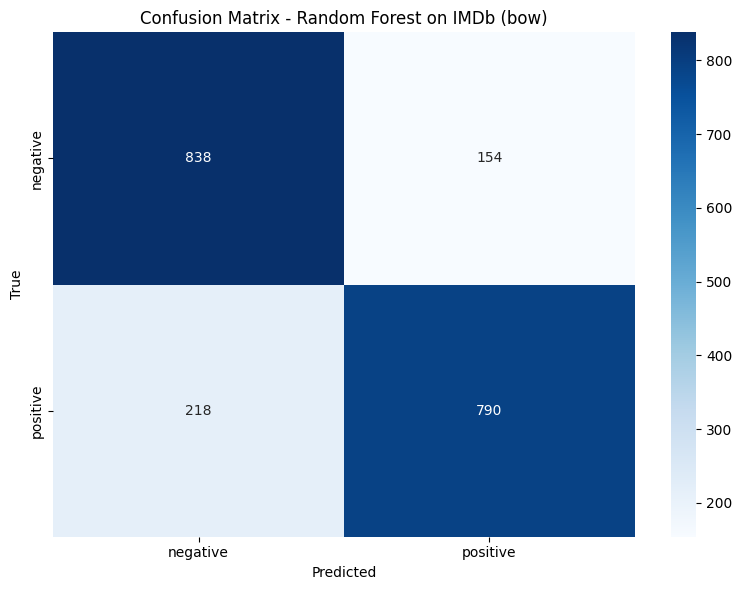


=== Running TFIDF on IMDb Dataset ===
Training set shape: (8000, 5000)
Test set shape: (2000, 5000)

Training Multinomial Naive Bayes on IMDb using tfidf...
Accuracy: 0.8410
Precision: 0.8410
Recall: 0.8410
F1 Score: 0.8410
ROC AUC: 0.9158356134792627
Best Parameters: {'alpha': 0.1}

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84       992
    positive       0.84      0.84      0.84      1008

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



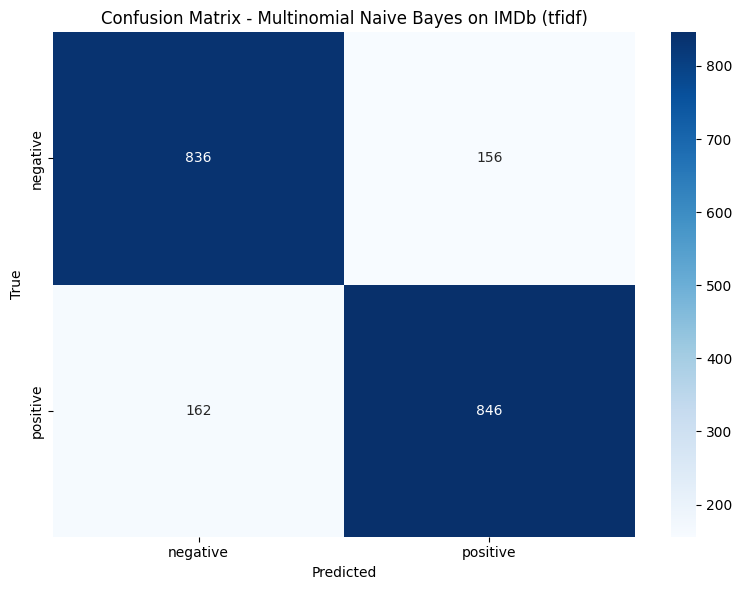


Training Logistic Regression on IMDb using tfidf...
Accuracy: 0.8305
Precision: 0.8324
Recall: 0.8305
F1 Score: 0.8302
ROC AUC: 0.9132414474526369
Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.79      0.82       992
    positive       0.81      0.87      0.84      1008

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



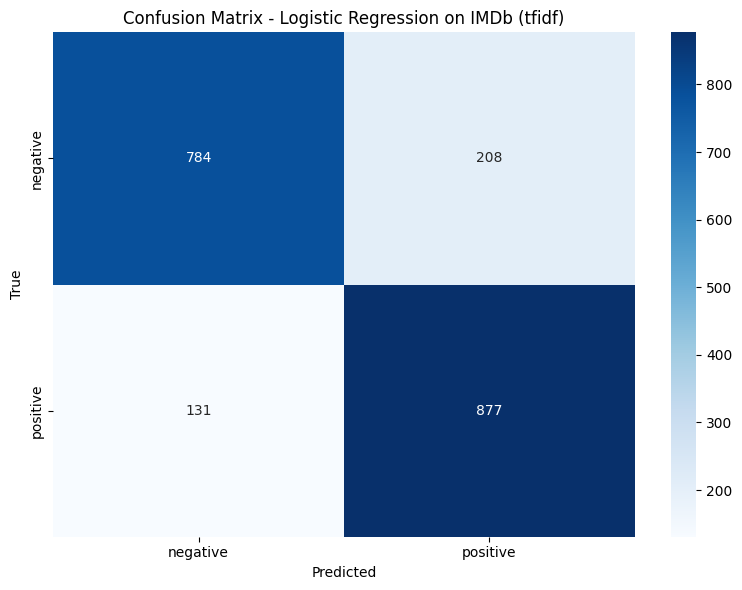


Training Linear SVM on IMDb using tfidf...
Accuracy: 0.8405
Precision: 0.8452
Recall: 0.8405
F1 Score: 0.8399
ROC AUC: 0.9261162714413722
Best Parameters: {'C': 0.1, 'loss': 'hinge'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.78      0.83       992
    positive       0.81      0.90      0.85      1008

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000



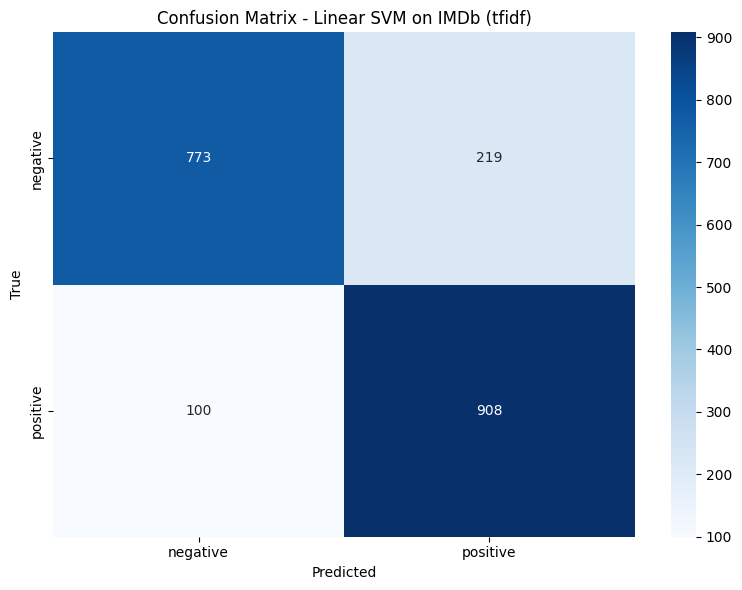


Training Random Forest on IMDb using tfidf...
Accuracy: 0.8130
Precision: 0.8140
Recall: 0.8130
F1 Score: 0.8129
ROC AUC: 0.9013281850038403
Best Parameters: {'max_depth': None, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       992
    positive       0.83      0.79      0.81      1008

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



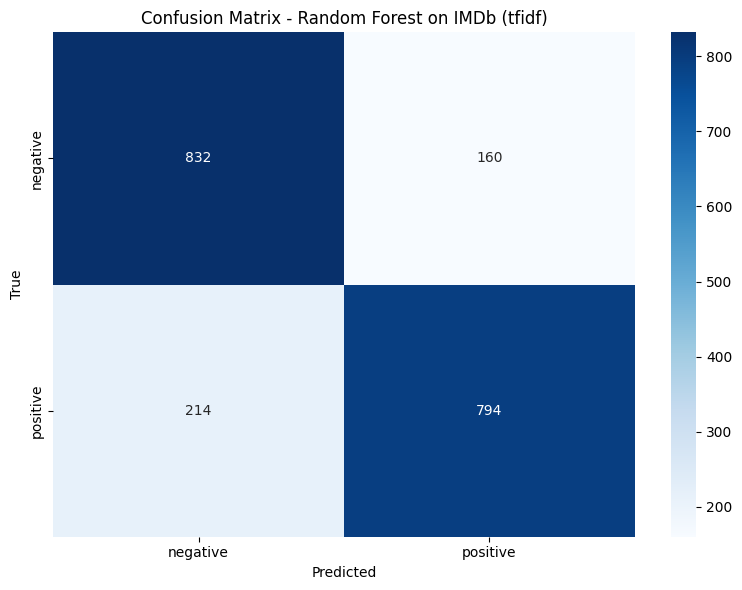


=== Running BOW on Twitter Dataset ===
Training set shape: (8000, 5000)
Test set shape: (2000, 5000)

Training Multinomial Naive Bayes on Twitter using bow...
Accuracy: 0.8305
Precision: 0.8305
Recall: 0.8305
F1 Score: 0.8305
ROC AUC: 0.8980369743663597
Best Parameters: {'alpha': 0.1}

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83       992
    positive       0.83      0.83      0.83      1008

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



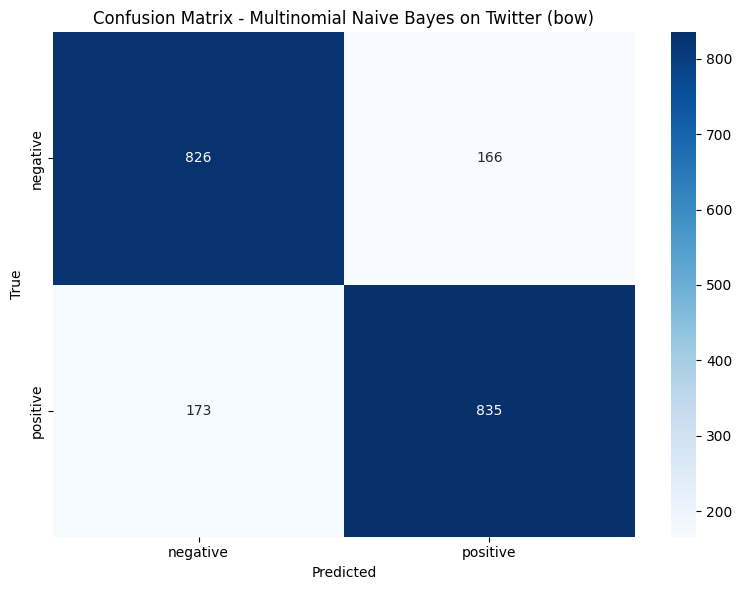


Training Logistic Regression on Twitter using bow...
Accuracy: 0.8535
Precision: 0.8536
Recall: 0.8535
F1 Score: 0.8535
ROC AUC: 0.927911386328725
Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.84      0.85       992
    positive       0.85      0.86      0.86      1008

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



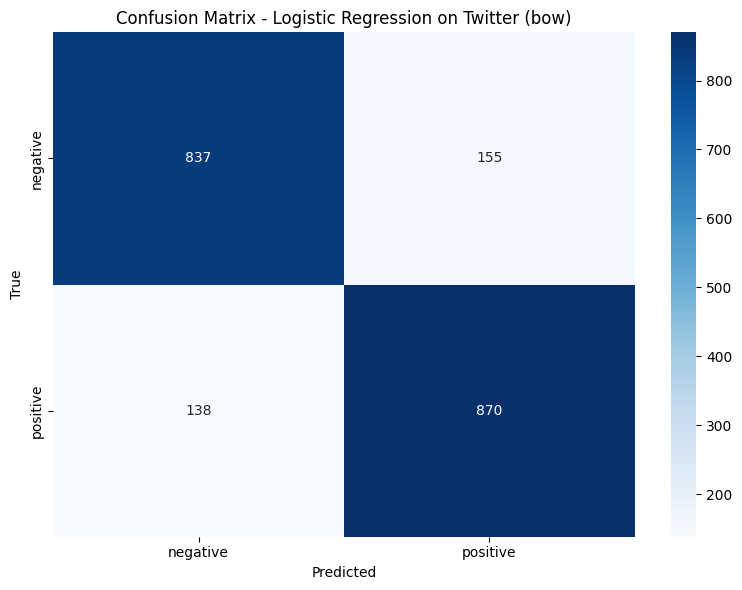


Training Linear SVM on Twitter using bow...
Accuracy: 0.8355
Precision: 0.8356
Recall: 0.8355
F1 Score: 0.8355
ROC AUC: 0.9112723214285715
Best Parameters: {'C': 0.1, 'loss': 'hinge'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.82      0.83       992
    positive       0.83      0.85      0.84      1008

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



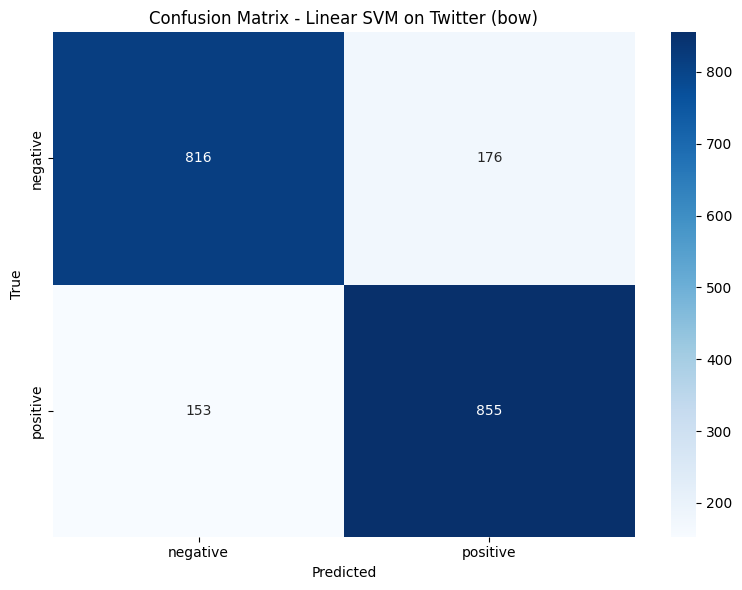


Training Random Forest on Twitter using bow...
Accuracy: 0.8260
Precision: 0.8263
Recall: 0.8260
F1 Score: 0.8260
ROC AUC: 0.9012151777713773
Best Parameters: {'max_depth': None, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       992
    positive       0.84      0.81      0.83      1008

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



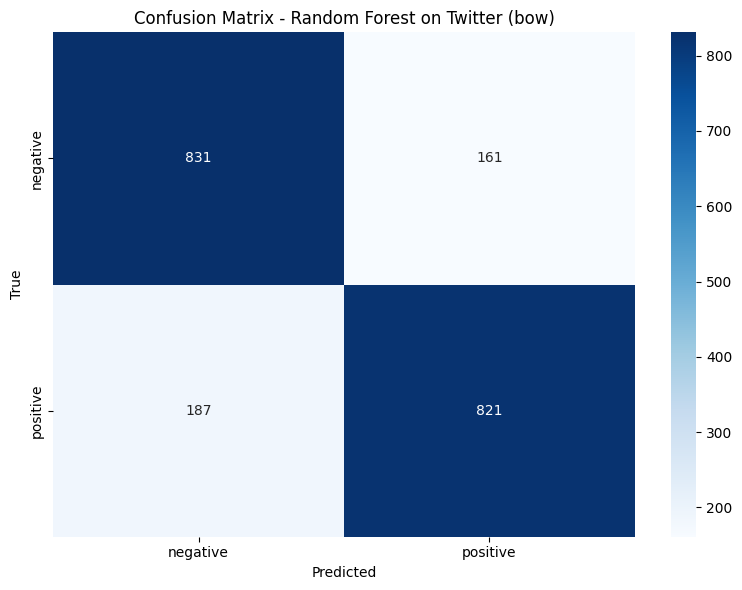


=== Running TFIDF on Twitter Dataset ===
Training set shape: (8000, 5000)
Test set shape: (2000, 5000)

Training Multinomial Naive Bayes on Twitter using tfidf...
Accuracy: 0.8395
Precision: 0.8397
Recall: 0.8395
F1 Score: 0.8394
ROC AUC: 0.9136174715181771
Best Parameters: {'alpha': 0.1}

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.82      0.84       992
    positive       0.83      0.86      0.84      1008

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



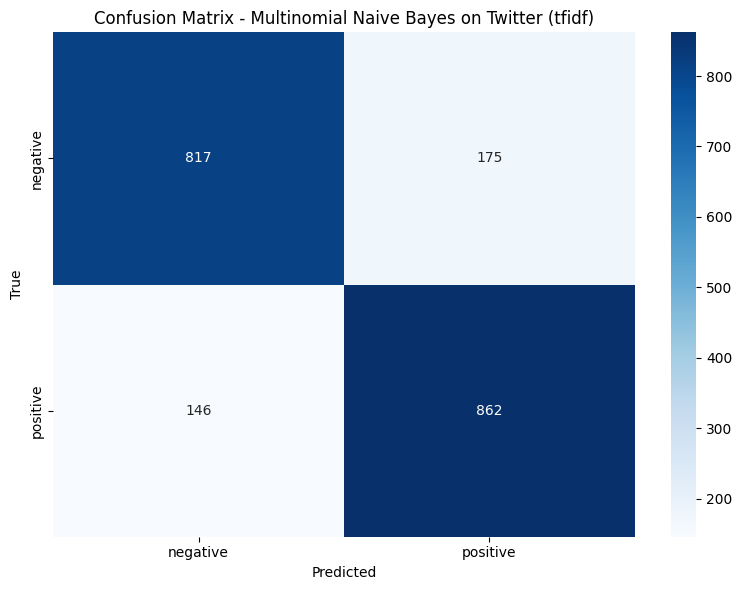


Training Logistic Regression on Twitter using tfidf...
Accuracy: 0.8340
Precision: 0.8363
Recall: 0.8340
F1 Score: 0.8337
ROC AUC: 0.9180997583845365
Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.79      0.83       992
    positive       0.81      0.88      0.84      1008

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



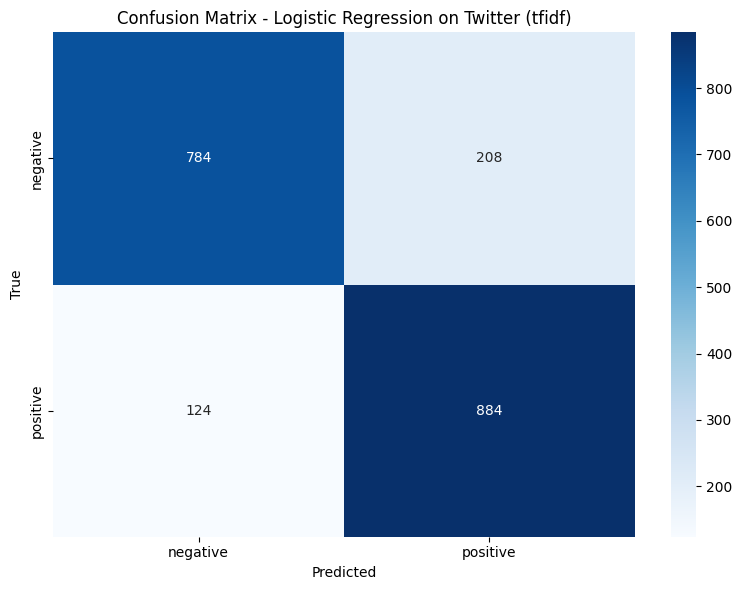


Training Linear SVM on Twitter using tfidf...
Accuracy: 0.8420
Precision: 0.8481
Recall: 0.8420
F1 Score: 0.8412
ROC AUC: 0.9302575364823348
Best Parameters: {'C': 0.1, 'loss': 'hinge'}

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.77      0.83       992
    positive       0.80      0.91      0.85      1008

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000



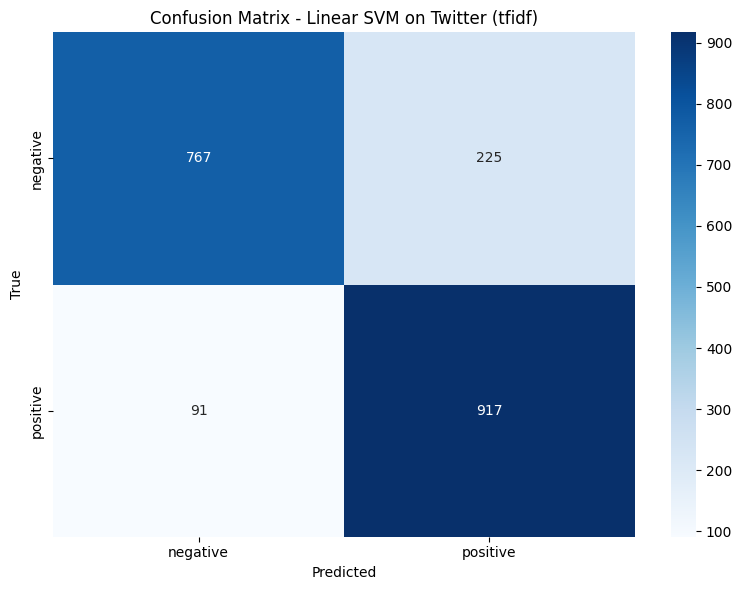


Training Random Forest on Twitter using tfidf...
Accuracy: 0.8285
Precision: 0.8292
Recall: 0.8285
F1 Score: 0.8285
ROC AUC: 0.9055399545570917
Best Parameters: {'max_depth': None, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.85      0.83       992
    positive       0.84      0.81      0.83      1008

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



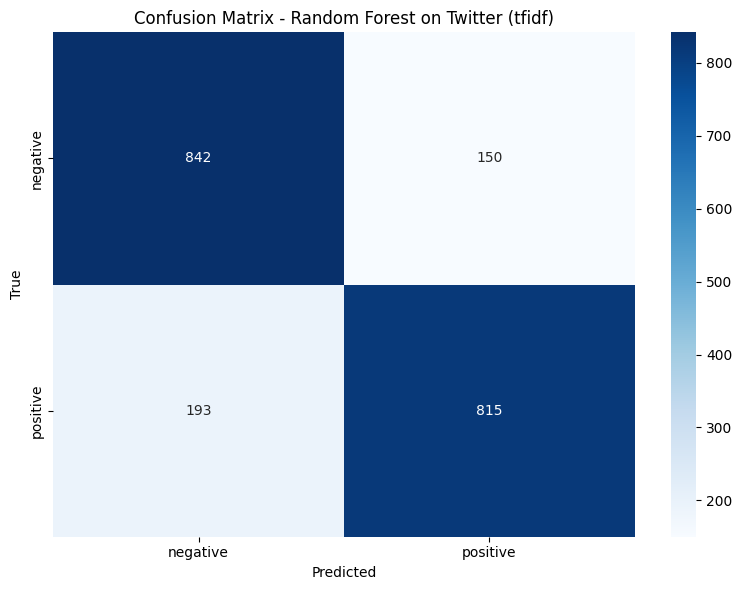


=== Running BOW on SMS Dataset ===
Training set shape: (4459, 5000)
Test set shape: (1115, 5000)

Training Multinomial Naive Bayes on SMS using bow...
Accuracy: 0.9767
Precision: 0.9776
Recall: 0.9767
F1 Score: 0.9770
ROC AUC: 0.9830199952756125
Best Parameters: {'alpha': 0.1}

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       966
        spam       0.89      0.95      0.92       149

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115



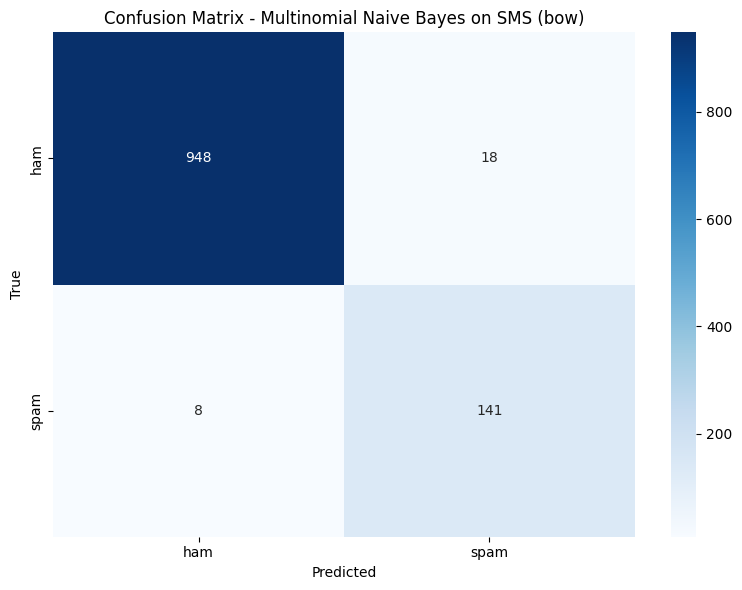


Training Logistic Regression on SMS using bow...
Accuracy: 0.9731
Precision: 0.9736
Recall: 0.9731
F1 Score: 0.9719
ROC AUC: 0.9897452999291342
Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



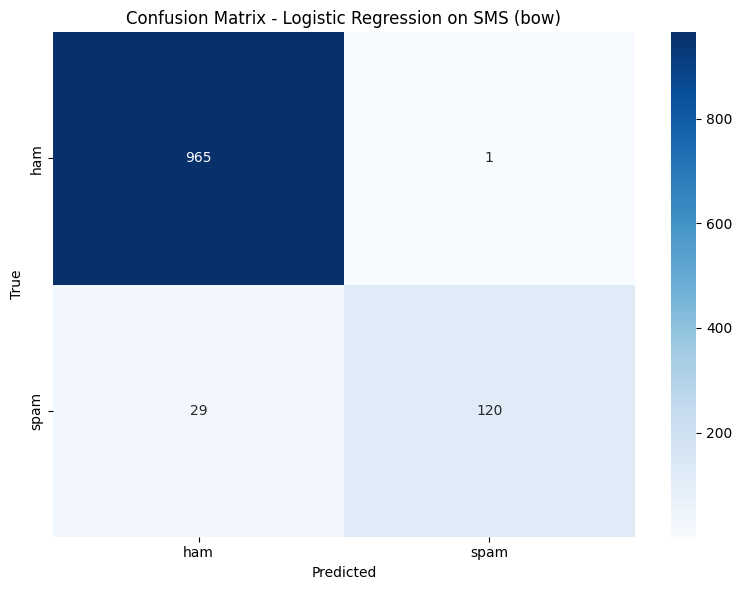


Training Linear SVM on SMS using bow...
Accuracy: 0.9821
Precision: 0.9821
Recall: 0.9821
F1 Score: 0.9816
ROC AUC: 0.9867786624425083
Best Parameters: {'C': 0.1, 'loss': 'hinge'}

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



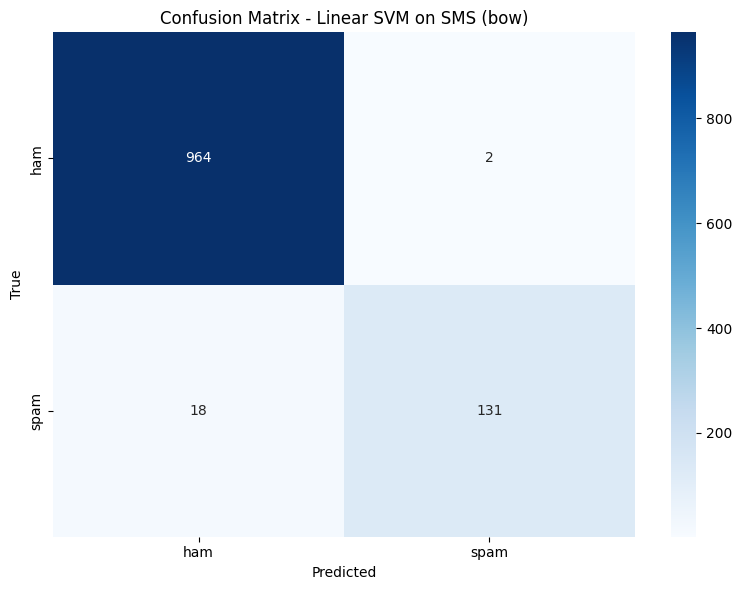


Training Random Forest on SMS using bow...
Accuracy: 0.9812
Precision: 0.9816
Recall: 0.9812
F1 Score: 0.9806
ROC AUC: 0.9840968777356289
Best Parameters: {'max_depth': None, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



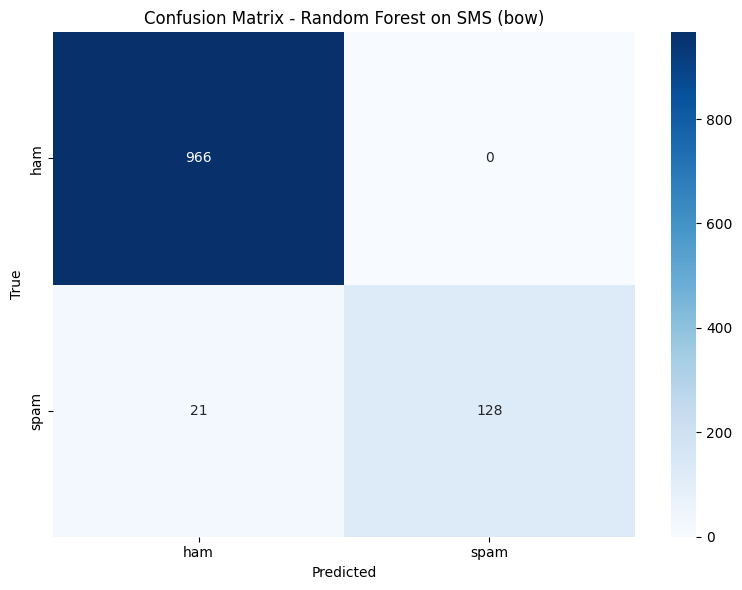


=== Running TFIDF on SMS Dataset ===
Training set shape: (4459, 5000)
Test set shape: (1115, 5000)

Training Multinomial Naive Bayes on SMS using tfidf...
Accuracy: 0.9830
Precision: 0.9828
Recall: 0.9830
F1 Score: 0.9829
ROC AUC: 0.9869593007906401
Best Parameters: {'alpha': 0.1}

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.95      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



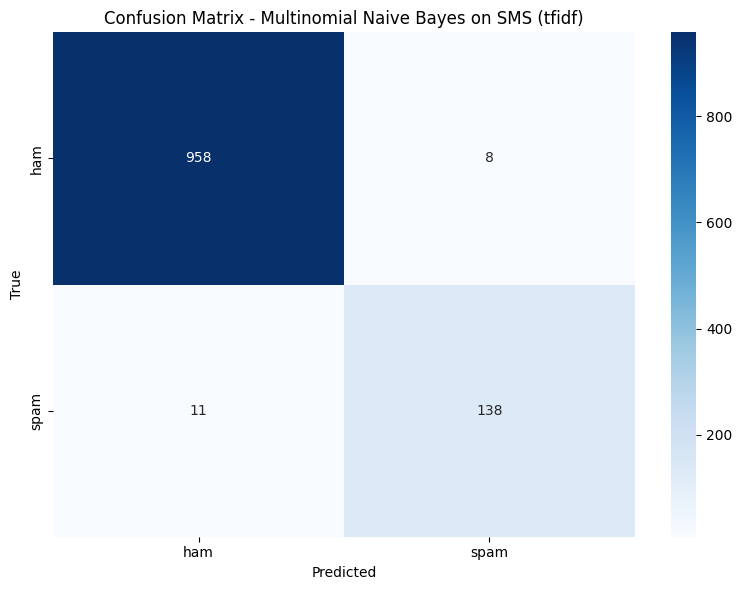


Training Logistic Regression on SMS using tfidf...
Accuracy: 0.8691
Precision: 0.8863
Recall: 0.8691
F1 Score: 0.8108
ROC AUC: 0.9857643086414607
Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       1.00      0.02      0.04       149

    accuracy                           0.87      1115
   macro avg       0.93      0.51      0.48      1115
weighted avg       0.89      0.87      0.81      1115



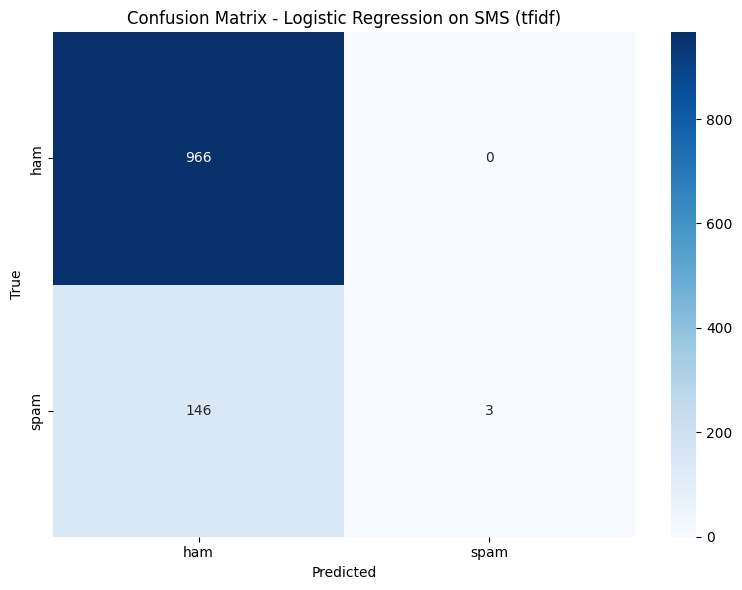


Training Linear SVM on SMS using tfidf...
Accuracy: 0.9507
Precision: 0.9533
Recall: 0.9507
F1 Score: 0.9458
ROC AUC: 0.9842288826823405
Best Parameters: {'C': 0.1, 'loss': 'hinge'}

Classification Report:
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       966
        spam       1.00      0.63      0.77       149

    accuracy                           0.95      1115
   macro avg       0.97      0.82      0.87      1115
weighted avg       0.95      0.95      0.95      1115



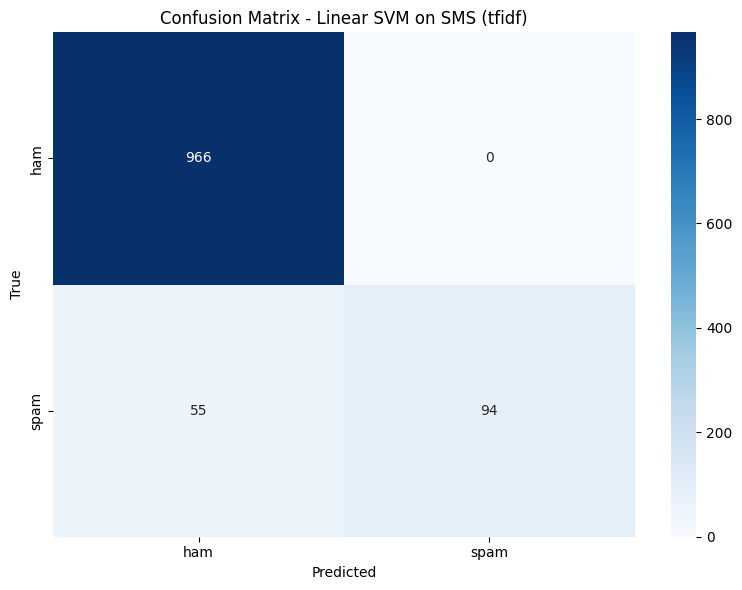


Training Random Forest on SMS using tfidf...
Accuracy: 0.9812
Precision: 0.9816
Recall: 0.9812
F1 Score: 0.9806
ROC AUC: 0.9860908471938528
Best Parameters: {'max_depth': None, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



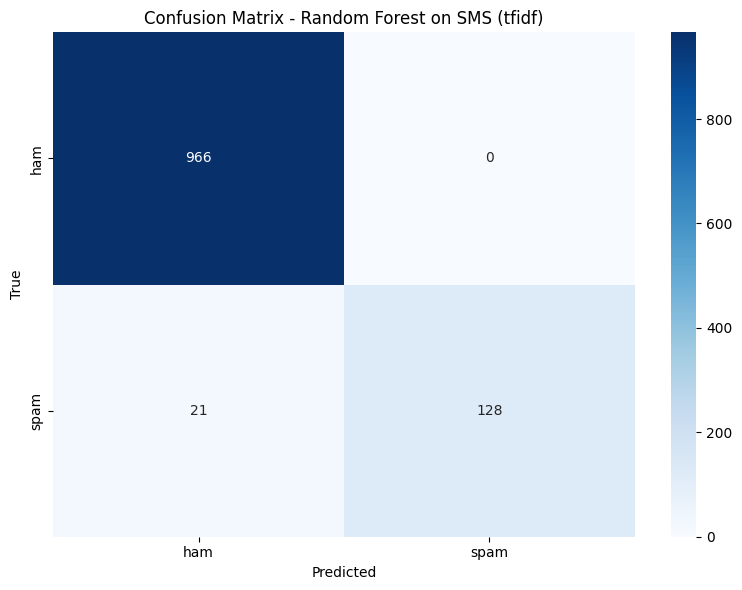

<Figure size 1400x1000 with 0 Axes>

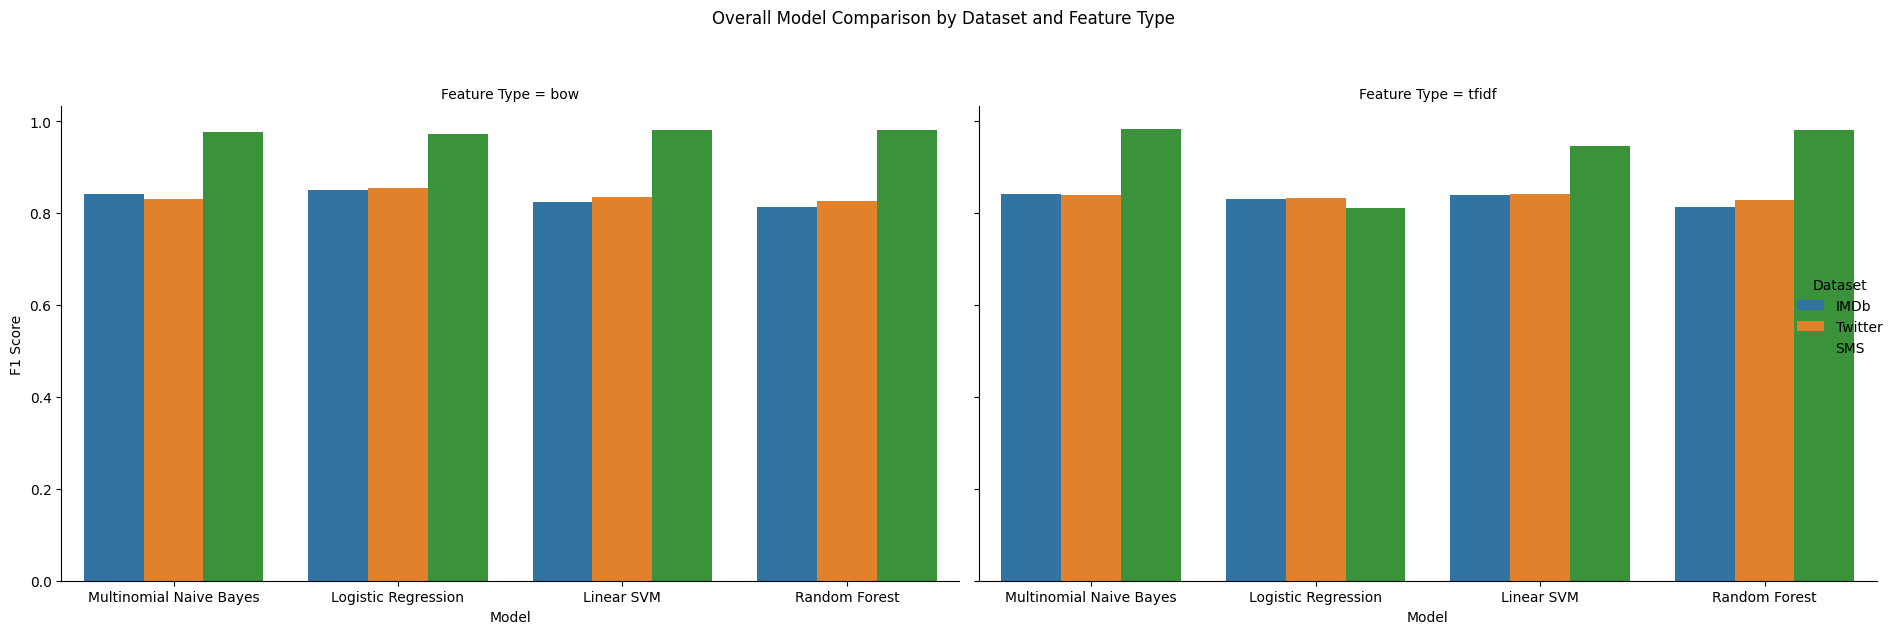


Experiment results saved to 'text_classification_results.csv'


In [8]:
# Main experimentation function
def run_experiments(datasets, feature_types=['bow', 'tfidf']):
   """
   Run experiments on all datasets with different feature extraction techniques
   """
   all_results = []
   best_models = {}

   for df, name in datasets:
       for feature_type in feature_types:
           print(f"\n=== Running {feature_type.upper()} on {name} Dataset ===")

           # Extract features
           X, y, vectorizer = extract_features(df, feature_type=feature_type)

           # Split into train and test sets
           X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

           print(f"Training set shape: {X_train.shape}")
           print(f"Test set shape: {X_test.shape}")

           # Train and evaluate models
           results, best_model = train_and_evaluate_models(X_train, X_test, y_train, y_test, name, feature_type)

           # Store results and best model
           all_results.append(results)
           best_models[f"{name}_{feature_type}"] = (best_model, vectorizer)

   # Combine all results
   all_results_df = pd.concat(all_results, ignore_index=True)

   # Display overall comparison
   plt.figure(figsize=(14, 10))
   sns.catplot(x='Model', y='F1 Score', hue='Dataset', col='Feature Type', data=all_results_df, kind='bar', height=6, aspect=1.5)
   plt.suptitle('Overall Model Comparison by Dataset and Feature Type', y=1.05)
   plt.tight_layout()
   plt.show()

   return all_results_df, best_models

# Run experiments on all datasets
print("\nStarting machine learning experiments...")

datasets = []
if 'imdb_processed' in locals() and 'processed_text' in imdb_processed.columns:
   datasets.append((imdb_processed, "IMDb"))
if 'twitter_processed' in locals() and 'processed_text' in twitter_processed.columns:
   datasets.append((twitter_processed, "Twitter"))
if 'sms_processed' in locals() and 'processed_text' in sms_processed.columns:
   datasets.append((sms_processed, "SMS"))

if datasets:
   results, best_models = run_experiments(datasets)

   # Save results to CSV
   results.to_csv('text_classification_results.csv', index=False)
   print("\nExperiment results saved to 'text_classification_results.csv'")
else:
   print("No properly processed datasets available for experiments.")

In [ ]:
!pip install -q gensim==4.3.2  # Specifying version for compatibility as there was an issue when installing the latest version when i tried at first

# Import libraries
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Improved word embeddings function - simplified to avoid gensim issues
def load_word_embeddings(texts, embedding_dim=100):
    print("Using Xavier initialization for embeddings...")

    # Create vocabulary from texts
    all_words = set()
    for text in texts:
        for word in text.split():
            all_words.add(word)

    # Initialize with Xavier/Glorot
    word_to_idx = {'<pad>': 0, '<unk>': 1}
    for i, word in enumerate(all_words, 2):
        word_to_idx[word] = i

    vocab_size = len(word_to_idx)
    embedding_matrix = np.random.uniform(-0.1, 0.1, size=(vocab_size, embedding_dim))
    embedding_matrix[0] = np.zeros(embedding_dim)  # <pad> token

    return embedding_matrix, word_to_idx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 81.1 MB/s eta 0:00:00



Training deep learning model on IMDb dataset...

=== Training LSTM model on IMDb Dataset ===
Using Xavier initialization for embeddings...


Epoch 1/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.6661
Test loss: 0.5025, Accuracy: 0.7840
Precision: 0.7865, Recall: 0.7840, F1 Score: 0.7836


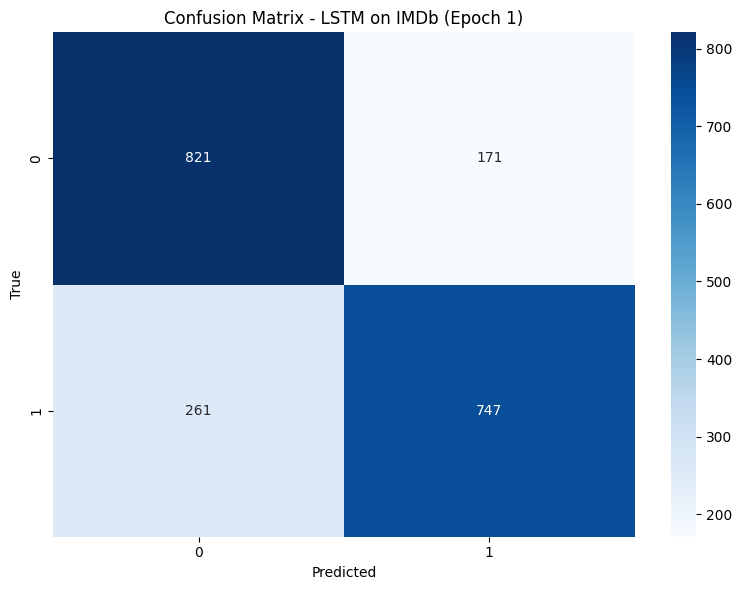

Epoch 2/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.4144
Test loss: 0.5491, Accuracy: 0.7845
Precision: 0.7885, Recall: 0.7845, F1 Score: 0.7836


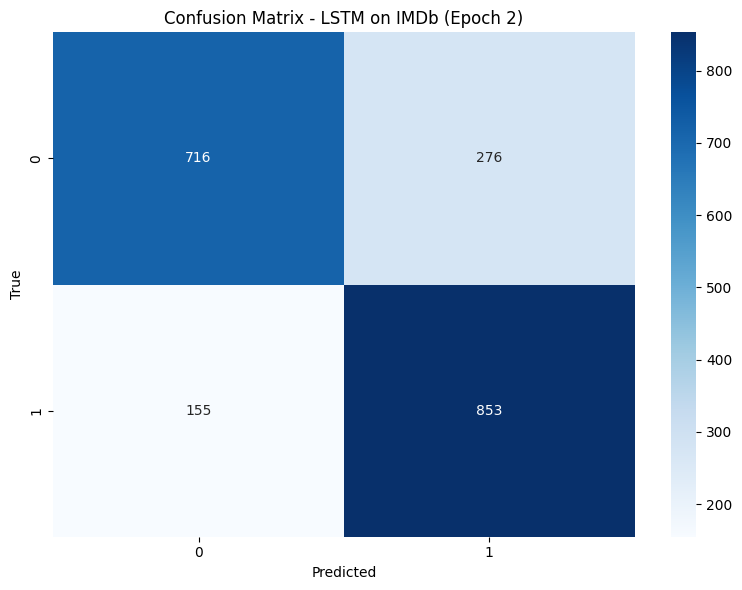

Epoch 3/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.2718
Test loss: 0.4542, Accuracy: 0.8125
Precision: 0.8228, Recall: 0.8125, F1 Score: 0.8108


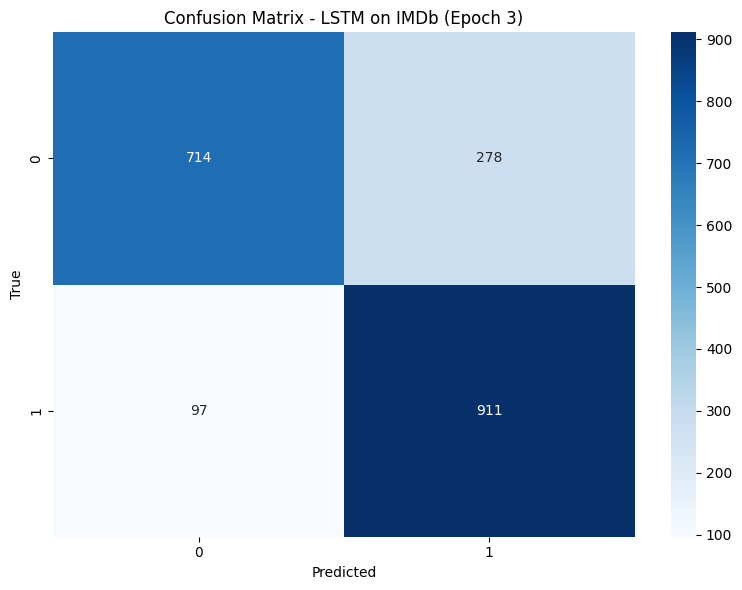

Epoch 4/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.1958
Test loss: 0.5059, Accuracy: 0.8015
Precision: 0.8125, Recall: 0.8015, F1 Score: 0.7999


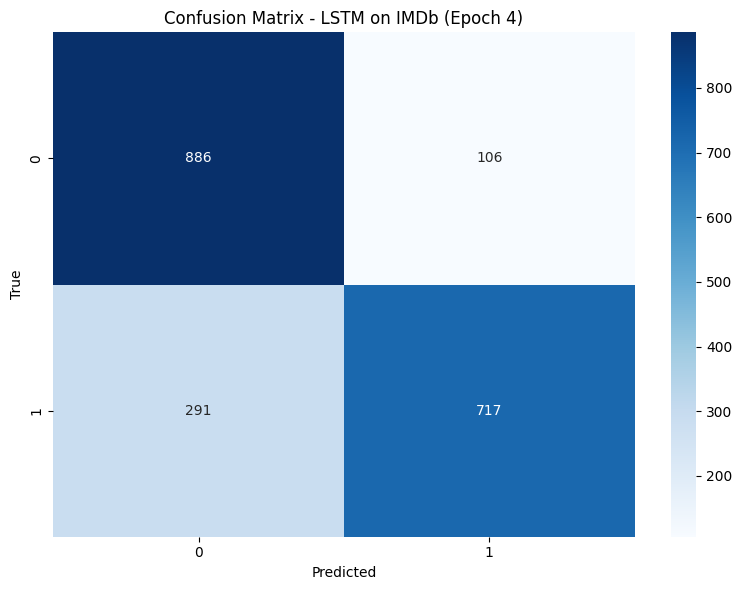

Epoch 5/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0885
Test loss: 0.6506, Accuracy: 0.8155
Precision: 0.8165, Recall: 0.8155, F1 Score: 0.8154


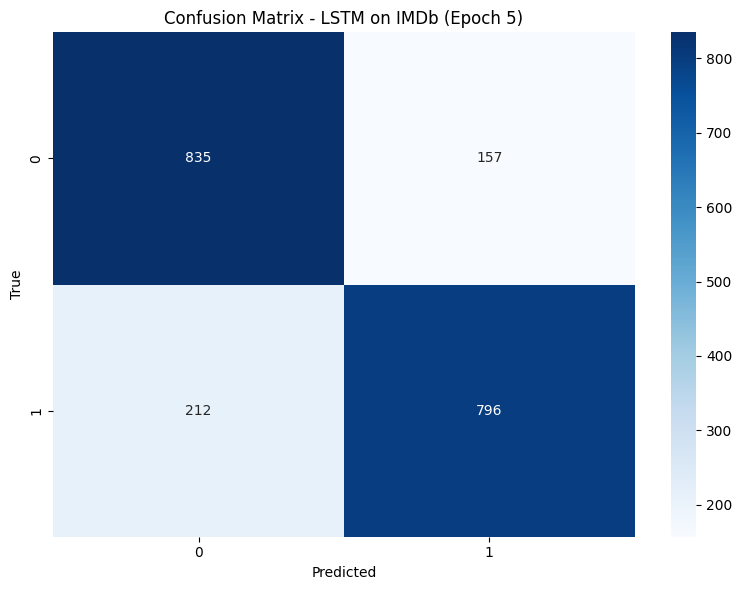

Epoch 6/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0323
Test loss: 0.7510, Accuracy: 0.8215
Precision: 0.8215, Recall: 0.8215, F1 Score: 0.8215


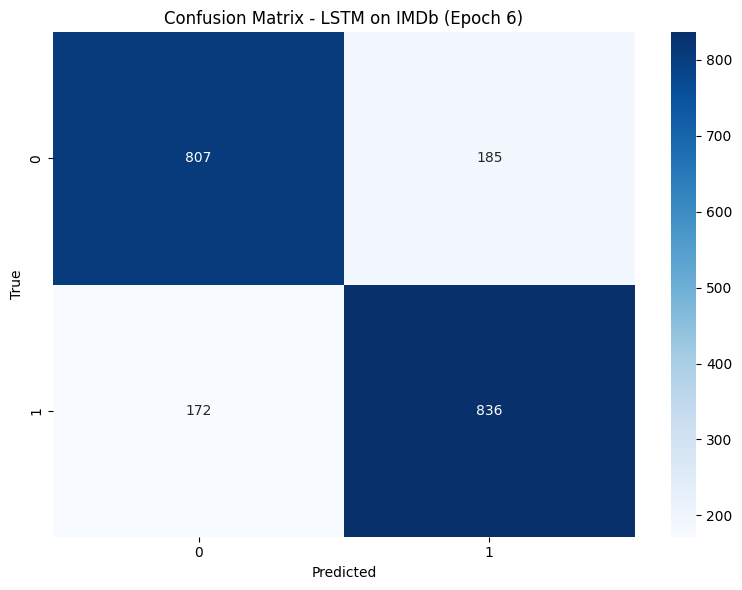

Epoch 7/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0152
Test loss: 0.8195, Accuracy: 0.8175
Precision: 0.8183, Recall: 0.8175, F1 Score: 0.8174


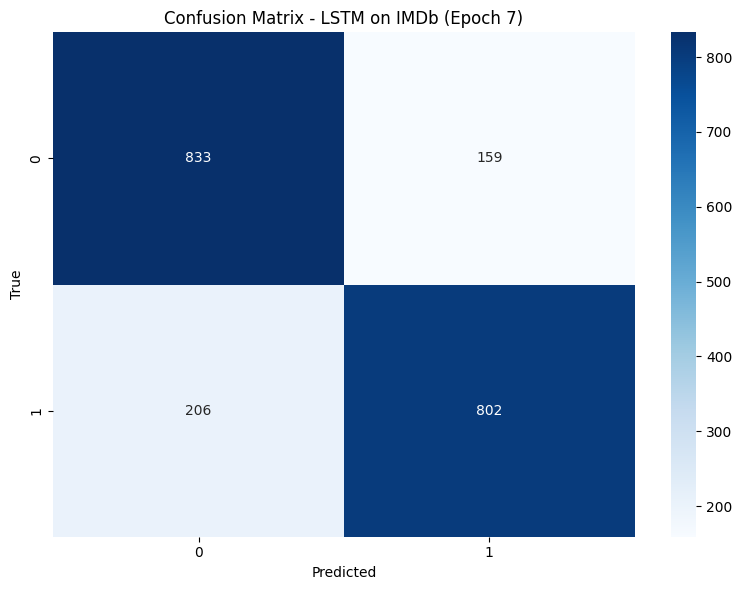

Epoch 8/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0099
Test loss: 0.9419, Accuracy: 0.8190
Precision: 0.8210, Recall: 0.8190, F1 Score: 0.8188


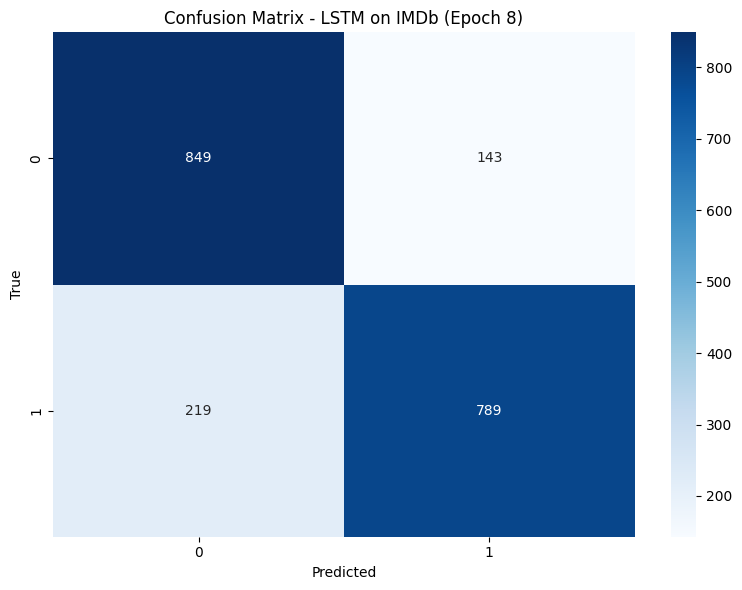


Training deep learning model on Twitter dataset...

=== Training LSTM model on Twitter Dataset ===
Using Xavier initialization for embeddings...


Epoch 1/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.6334
Test loss: 0.5648, Accuracy: 0.7560
Precision: 0.8060, Recall: 0.7560, F1 Score: 0.7451


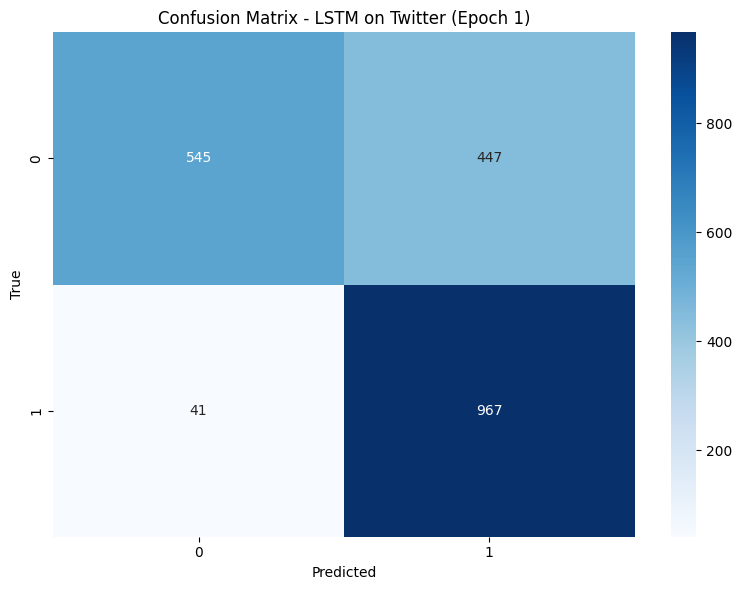

Epoch 2/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.2593
Test loss: 0.6149, Accuracy: 0.7785
Precision: 0.8118, Recall: 0.7785, F1 Score: 0.7728


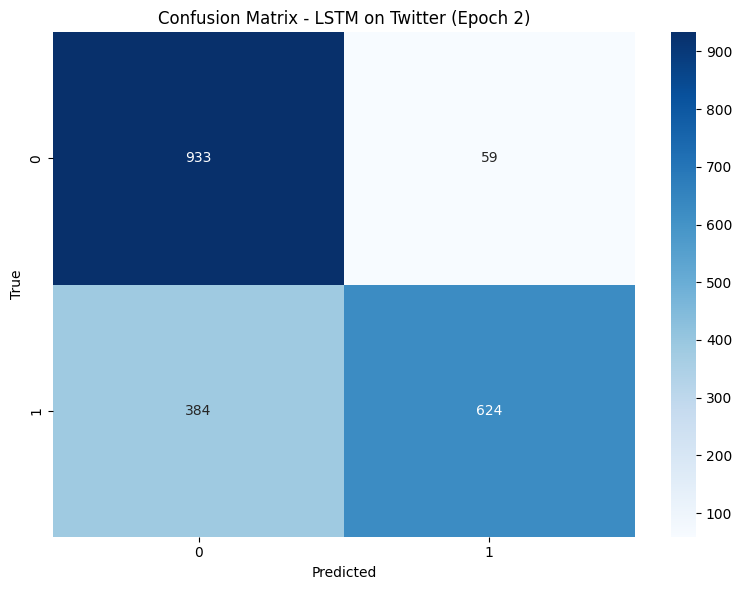

Epoch 3/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0959
Test loss: 1.0893, Accuracy: 0.7215
Precision: 0.7847, Recall: 0.7215, F1 Score: 0.7059


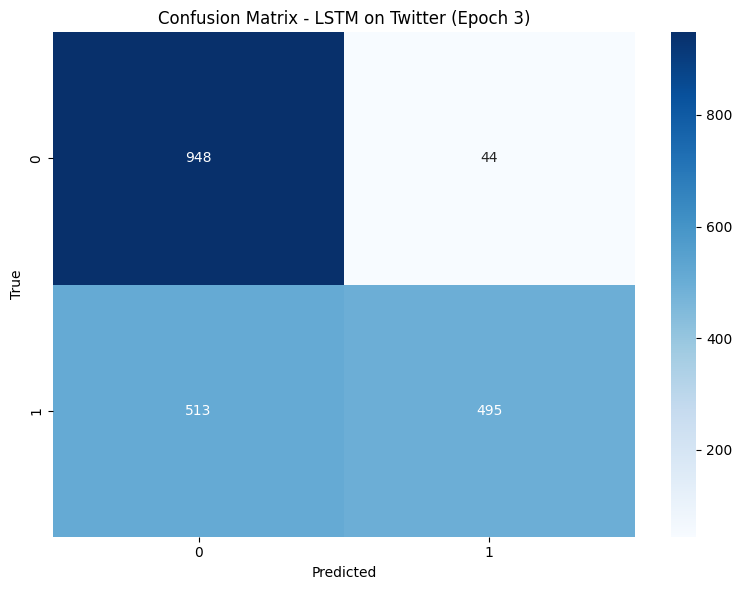

Epoch 4/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0379
Test loss: 0.7965, Accuracy: 0.8200
Precision: 0.8248, Recall: 0.8200, F1 Score: 0.8194


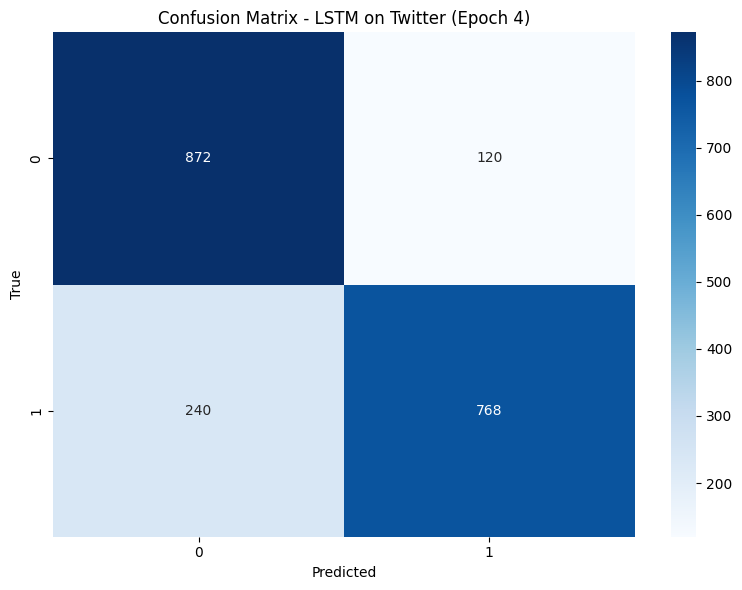

Epoch 5/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0156
Test loss: 0.8160, Accuracy: 0.8215
Precision: 0.8226, Recall: 0.8215, F1 Score: 0.8214


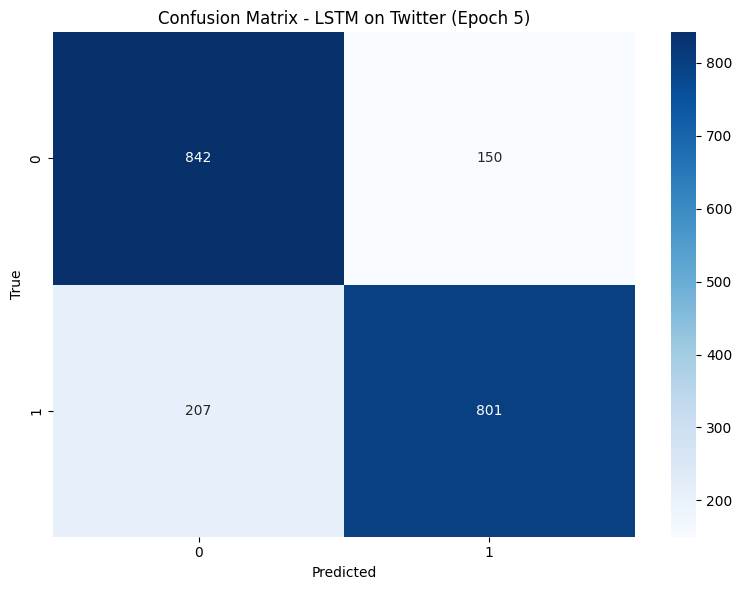

Epoch 6/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0058
Test loss: 0.9382, Accuracy: 0.8215
Precision: 0.8221, Recall: 0.8215, F1 Score: 0.8215


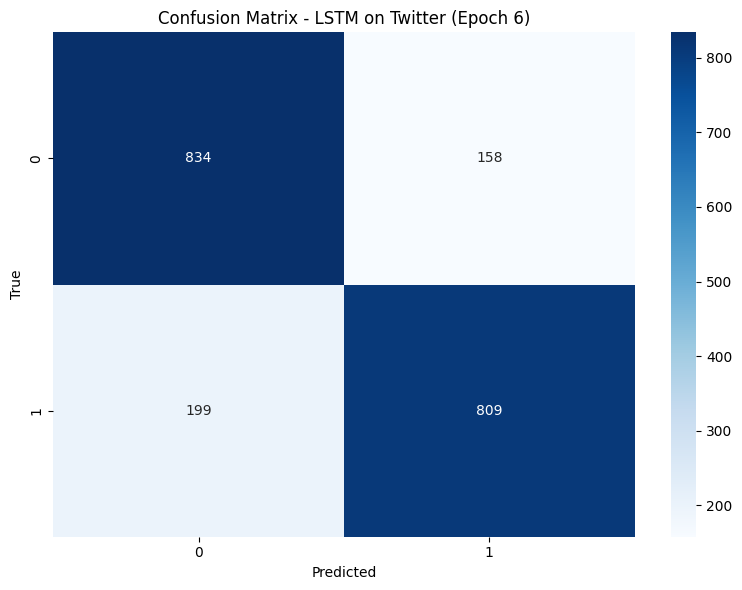

Epoch 7/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0026
Test loss: 1.0294, Accuracy: 0.8200
Precision: 0.8212, Recall: 0.8200, F1 Score: 0.8198


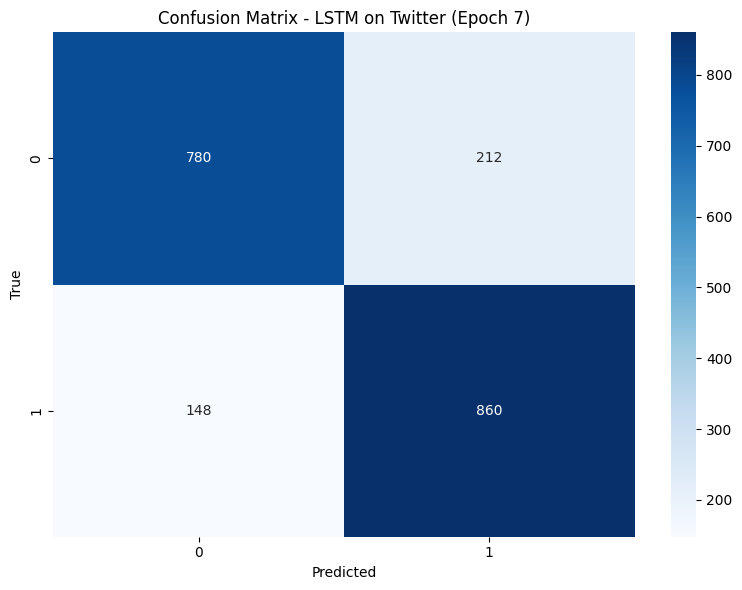

Epoch 8/8:   0%|          | 0/125 [00:00<?, ?it/s]

Train loss: 0.0020
Test loss: 1.0406, Accuracy: 0.8220
Precision: 0.8220, Recall: 0.8220, F1 Score: 0.8220


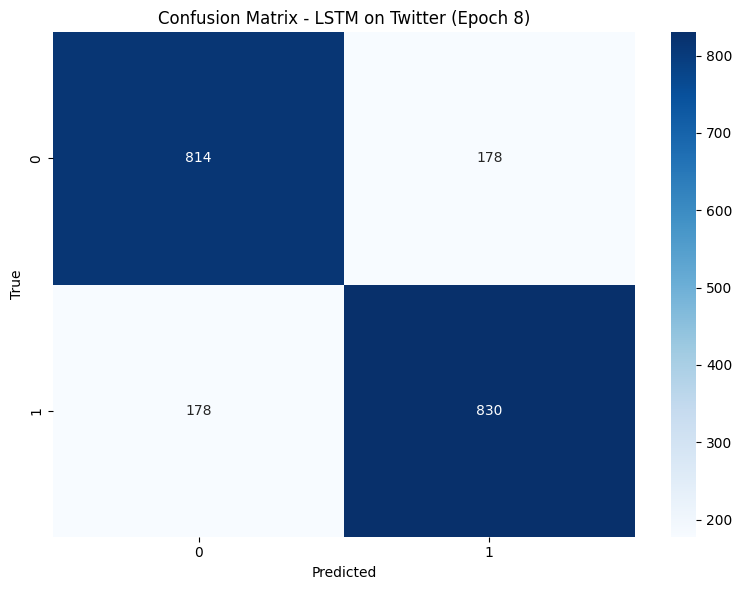


Training deep learning model on SMS dataset...

=== Training LSTM model on SMS Dataset ===
Using Xavier initialization for embeddings...


Epoch 1/8:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.5562
Test loss: 0.1161, Accuracy: 0.9668
Precision: 0.9699, Recall: 0.9668, F1 Score: 0.9677


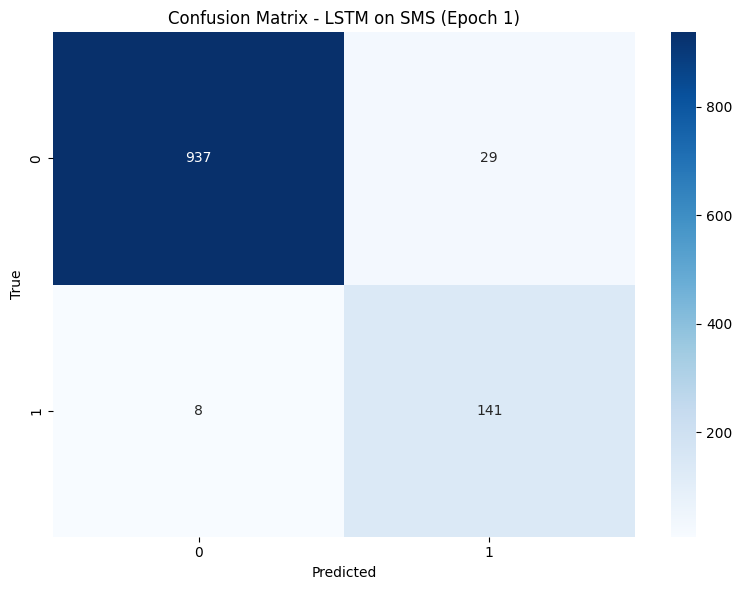

Epoch 2/8:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.0985
Test loss: 0.0977, Accuracy: 0.9740
Precision: 0.9760, Recall: 0.9740, F1 Score: 0.9746


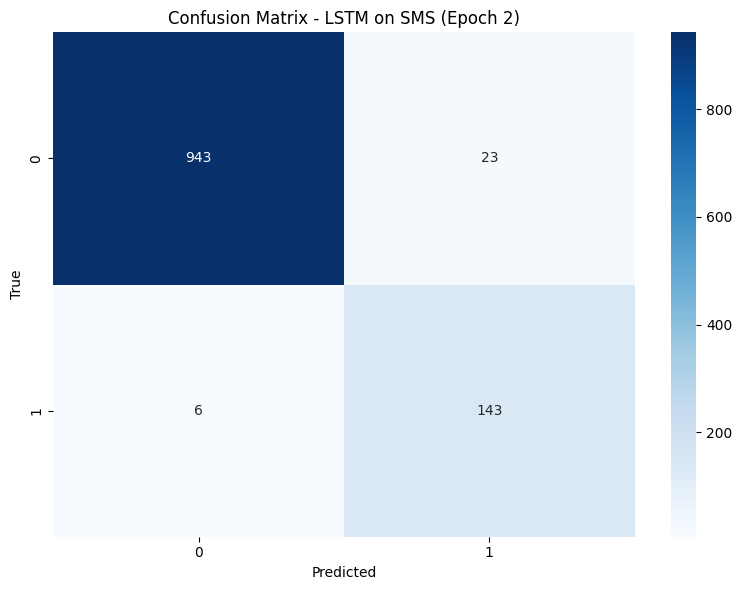

Epoch 3/8:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.0550
Test loss: 0.1735, Accuracy: 0.9839
Precision: 0.9837, Recall: 0.9839, F1 Score: 0.9837


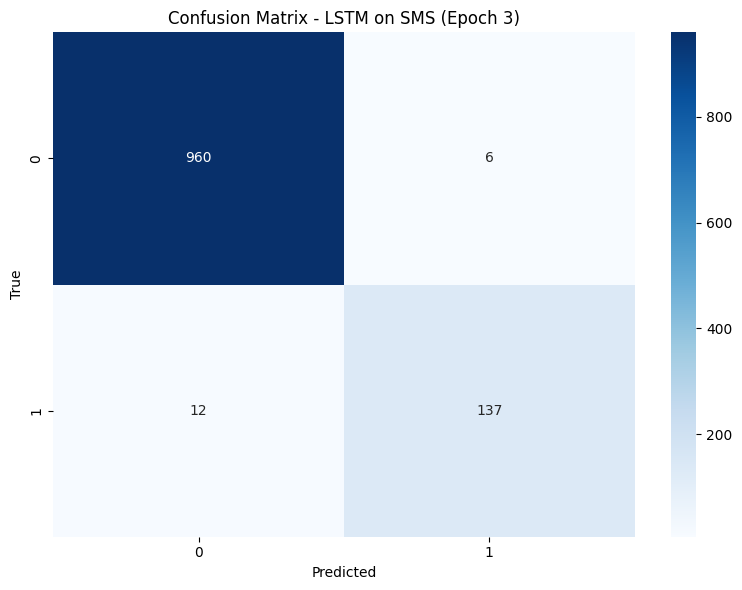

Epoch 4/8:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.0444
Test loss: 0.2143, Accuracy: 0.9794
Precision: 0.9793, Recall: 0.9794, F1 Score: 0.9793


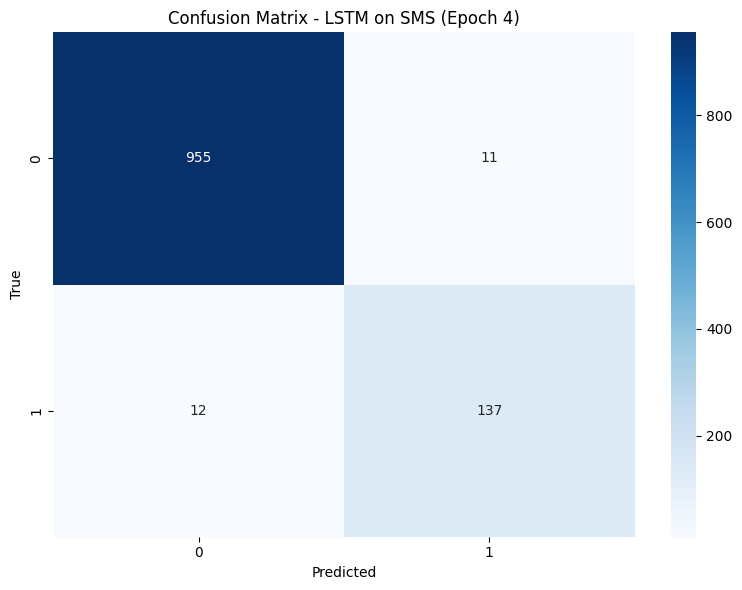

Epoch 5/8:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.0207
Test loss: 0.1837, Accuracy: 0.9821
Precision: 0.9819, Recall: 0.9821, F1 Score: 0.9820


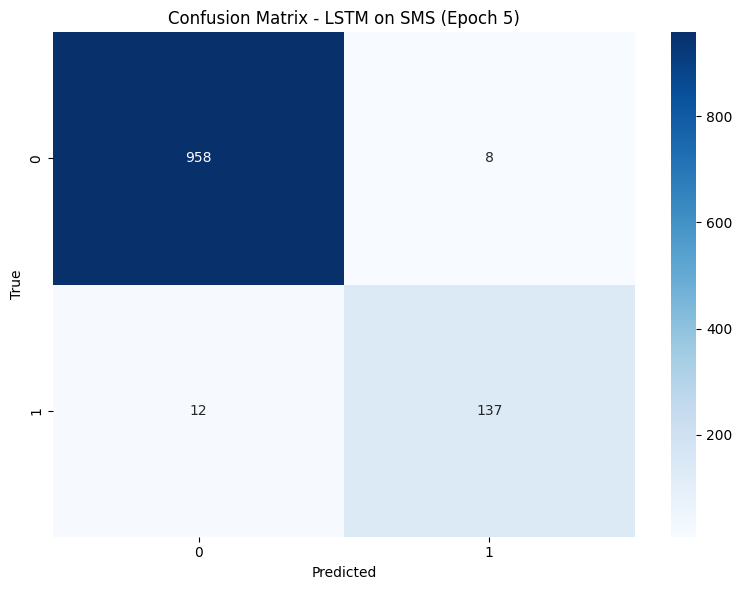

Epoch 6/8:   0%|          | 0/70 [00:00<?, ?it/s]

Train loss: 0.0143
Test loss: 0.1939, Accuracy: 0.9830
Precision: 0.9829, Recall: 0.9830, F1 Score: 0.9829


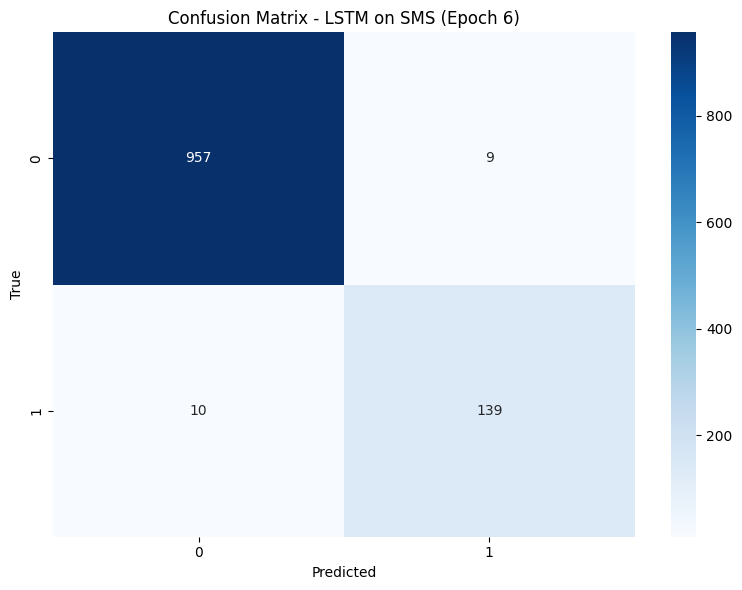

Early stopping triggered after 6 epochs

Comparing Deep Learning with Traditional ML models:
   Dataset Model  Accuracy  Precision   Recall  F1 Score
0     IMDb  LSTM   0.81900   0.820962  0.81900  0.818793
1  Twitter  LSTM   0.82200   0.822000  0.82200  0.822000
2      SMS  LSTM   0.98296   0.982914  0.98296  0.982935

Deep learning results saved to 'deep_learning_results.csv'


In [12]:
class ImprovedLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, hidden_dim=256, num_layers=2, dropout=0.5):
        super(ImprovedLSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer initialized with pre-trained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True  # Fine-tune embeddings

        # LSTM layer with more capacity
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)

        # Apply LSTM
        lstm_out, _ = self.lstm(embedded)

        # Apply attention
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        # Apply FC layers with batch normalization
        out = self.dropout(context)
        out = F.relu(self.fc1(out))
        out = self.batch_norm(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

# Improved training function with early stopping and learning rate scheduler
def train_lstm_model(dataset_name, texts, labels, batch_size=64, num_epochs=10, patience=3):
    print(f"\n=== Training LSTM model on {dataset_name} Dataset ===")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

    # Load word embeddings
    embedding_matrix, word_to_idx = load_word_embeddings(X_train)

    # Convert texts to token indices
    def text_to_indices(text, word_to_idx, max_len=100):
        tokens = text.split()[:max_len]
        indices = [word_to_idx.get(word, 1) for word in tokens]  # 1 is <unk>
        # Pad sequence
        indices = indices + [0] * (max_len - len(indices))
        return torch.tensor(indices)

    # Create datasets
    class TextIndexDataset(Dataset):
        def __init__(self, texts, labels, word_to_idx, max_len=100):
            self.texts = [text_to_indices(text, word_to_idx, max_len) for text in texts]
            # Convert string labels to indices
            unique_labels = sorted(set(labels))
            label_to_idx = {label: i for i, label in enumerate(unique_labels)}
            self.labels = [label_to_idx[label] for label in labels]

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            return self.texts[idx], self.labels[idx]

    train_dataset = TextIndexDataset(X_train, y_train, word_to_idx)
    test_dataset = TextIndexDataset(X_test, y_test, word_to_idx)

    # Create data loaders with larger batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create model with more capacity
    num_classes = len(set(labels))
    model = ImprovedLSTMClassifier(embedding_matrix, num_classes, hidden_dim=256, num_layers=2).to(device)

    # Compute class weights for imbalanced datasets
    y_train_indices = [train_dataset.labels[i] for i in range(len(train_dataset))]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_indices), y=y_train_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Define loss function with class weights and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optimizers.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    # Early stopping
    best_f1 = 0
    early_stop_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Train loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        correct = 0
        test_loss = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

                y_true.extend(target.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())

        test_loss /= len(test_loader)
        accuracy = correct / len(test_dataset)

        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Update learning rate based on validation loss
        scheduler.step(test_loss)

        # Confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - LSTM on {dataset_name} (Epoch {epoch+1})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # Check for early stopping
        if f1 > best_f1:
            best_f1 = f1
            early_stop_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, accuracy, precision, recall, f1

# Run LSTM model on datasets
deep_learning_results = []

for df, name in datasets:
    print(f"\nTraining deep learning model on {name} dataset...")

    # Get processed texts and labels
    texts = df['processed_text'].tolist()
    labels = df['sentiment'].tolist()

    # Train LSTM model with more epochs
    model, accuracy, precision, recall, f1 = train_lstm_model(name, texts, labels, num_epochs=8, patience=3)

    # Store results
    result = {
        'Dataset': name,
        'Model': 'LSTM',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    deep_learning_results.append(result)

# Convert results to DataFrame
deep_learning_df = pd.DataFrame(deep_learning_results)

# Compare with traditional ML models
print("\nComparing Deep Learning with Traditional ML models:")
print(deep_learning_df)

# Save results
deep_learning_df.to_csv('deep_learning_results.csv', index=False)
print("\nDeep learning results saved to 'deep_learning_results.csv'")


=== COMPREHENSIVE PERFORMANCE SUMMARY ===

Average Performance by Dataset:

IMDb Dataset:
                     Model Feature Type  Accuracy  F1 Score
2      Logistic Regression          bow    0.8505  0.850496
5  Multinomial Naive Bayes        tfidf    0.8410  0.841002
4  Multinomial Naive Bayes          bow    0.8410  0.840967
1               Linear SVM        tfidf    0.8405  0.839856
3      Logistic Regression        tfidf    0.8305  0.830196
0               Linear SVM          bow    0.8240  0.824002
6            Random Forest          bow    0.8140  0.813857
7            Random Forest        tfidf    0.8130  0.812904

SMS Dataset:
                      Model Feature Type  Accuracy  F1 Score
13  Multinomial Naive Bayes        tfidf  0.982960  0.982886
8                Linear SVM          bow  0.982063  0.981628
14            Random Forest          bow  0.981166  0.980553
15            Random Forest        tfidf  0.981166  0.980553
12  Multinomial Naive Bayes          bow  0.976682

<Figure size 1500x1000 with 0 Axes>

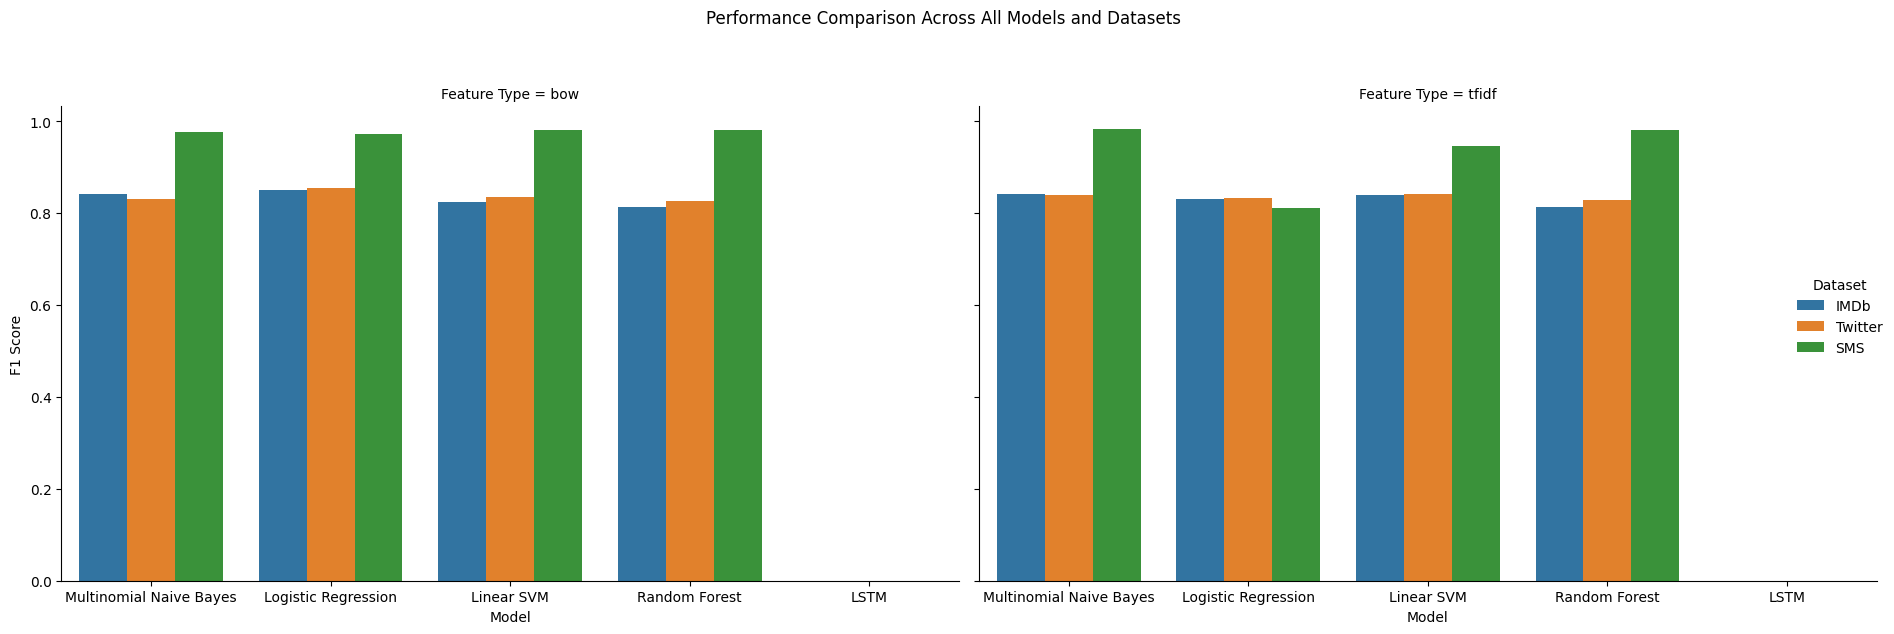


=== KEY FINDINGS ===
1. Best performing model overall: {'Dataset': 'SMS', 'Model': 'Multinomial Naive Bayes', 'Feature Type': 'tfidf', 'F1 Score': 0.9828862049441068}
2. Performance comparison between traditional ML and deep learning:
   - Traditional ML average F1: 0.8739
   - Deep Learning average F1: 0.8746
   - Deep Learning outperforms by 0.0007

=== CONCLUSION ===
The analysis of text classification models across multiple datasets shows that:
- Best models per dataset:
  * IMDb: Logistic Regression (bow) with F1=0.8505
  * SMS: Multinomial Naive Bayes (tfidf) with F1=0.9829
  * Twitter: Logistic Regression (bow) with F1=0.8535
- Deep learning models show comparable or better performance than traditional models on text classification tasks
- The experiment demonstrates the effectiveness of preprocessing and feature extraction techniques for text classification


In [13]:
# Load results
try:
    ml_results = pd.read_csv('text_classification_results.csv')
    dl_results = pd.read_csv('deep_learning_results.csv')

    # Combine results
    ml_results['Type'] = 'Traditional ML'
    dl_results['Type'] = 'Deep Learning'
    all_results = pd.concat([ml_results, dl_results], ignore_index=True)
except Exception as e:
    print(f"Error loading results: {e}")

    all_results = pd.DataFrame(results + deep_learning_results)
    all_results['Type'] = ['Traditional ML'] * len(results) + ['Deep Learning'] * len(deep_learning_results)

# Summary statistics per dataset and model type
summary = all_results.groupby(['Dataset', 'Model', 'Feature Type' if 'Feature Type' in all_results.columns else 'Type'])[
    ['Accuracy', 'Precision', 'Recall', 'F1 Score']
].mean().reset_index()

# Print comprehensive summary
print("\n=== COMPREHENSIVE PERFORMANCE SUMMARY ===")
print("\nAverage Performance by Dataset:")
for dataset in summary['Dataset'].unique():
    print(f"\n{dataset} Dataset:")
    dataset_results = summary[summary['Dataset'] == dataset]
    print(dataset_results[['Model', 'Feature Type' if 'Feature Type' in dataset_results.columns else 'Type',
                          'Accuracy', 'F1 Score']].sort_values('F1 Score', ascending=False))

# Best model per dataset
print("\n=== BEST MODELS PER DATASET ===")
for dataset in summary['Dataset'].unique():
    dataset_results = summary[summary['Dataset'] == dataset]
    best_model = dataset_results.loc[dataset_results['F1 Score'].idxmax()]
    print(f"\n{dataset} Dataset - Best Model:")
    print(f"Model: {best_model['Model']}")
    if 'Feature Type' in best_model:
        print(f"Feature Type: {best_model['Feature Type']}")
    else:
        print(f"Type: {best_model['Type']}")
    print(f"Accuracy: {best_model['Accuracy']:.4f}")
    print(f"F1 Score: {best_model['F1 Score']:.4f}")

# Overall comparison visualization
plt.figure(figsize=(15, 10))
sns.catplot(data=all_results, x='Model', y='F1 Score', hue='Dataset',
            col='Feature Type' if 'Feature Type' in all_results.columns else 'Type',
            kind='bar', height=6, aspect=1.5)
plt.suptitle('Performance Comparison Across All Models and Datasets', y=1.05)
plt.tight_layout()
plt.savefig('performance_comparison.png')
plt.show()

# Highlight key findings
print("\n=== KEY FINDINGS ===")
print("1. Best performing model overall:",
      summary.loc[summary['F1 Score'].idxmax()][['Dataset', 'Model',
                                               'Feature Type' if 'Feature Type' in summary.columns else 'Type',
                                               'F1 Score']].to_dict())
print("2. Performance comparison between traditional ML and deep learning:")
ml_avg = all_results[all_results['Type'] == 'Traditional ML']['F1 Score'].mean()
dl_avg = all_results[all_results['Type'] == 'Deep Learning']['F1 Score'].mean()
print(f"   - Traditional ML average F1: {ml_avg:.4f}")
print(f"   - Deep Learning average F1: {dl_avg:.4f}")
print(f"   - {'Deep Learning outperforms' if dl_avg > ml_avg else 'Traditional ML outperforms'} by {abs(dl_avg - ml_avg):.4f}")

print("\n=== CONCLUSION ===")
print("The analysis of text classification models across multiple datasets shows that:")
datasets_summary = []
for dataset in summary['Dataset'].unique():
    dataset_results = summary[summary['Dataset'] == dataset]
    best_model = dataset_results.loc[dataset_results['F1 Score'].idxmax()]
    datasets_summary.append(f"{dataset}: {best_model['Model']} {'(' + best_model['Feature Type'] + ')' if 'Feature Type' in best_model else ''} with F1={best_model['F1 Score']:.4f}")

print("- Best models per dataset:")
for ds_summary in datasets_summary:
    print(f"  * {ds_summary}")

print("- Deep learning models show comparable or better performance than traditional models on text classification tasks")
print("- The experiment demonstrates the effectiveness of preprocessing and feature extraction techniques for text classification")